In [68]:
import geopandas as gpd
import pandas as pd
pd.set_option('display.max_columns', 100)
from shapely.geometry import Point, LineString
from geopandas import GeoDataFrame
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
import numpy as np
import datetime
import json
from shapely import wkt

In [69]:
#reading deeds
deeds = pd.read_csv("data/SR1A_deeds/deeds_00_21_classified.csv", low_memory=False)

In [70]:
#ranking to find most recent deed change (labeled as 1)
deeds['deed_date_dt_x'] = pd.to_datetime(deeds['deed_date_dt_x'])
deeds['Rank'] = deeds.groupby('Property Location_x')['deed_date_dt_x'].rank(ascending=False)

In [71]:
#sorting based on street address and receipt date
deeds = deeds.sort_values(by=['Property Location_x','deed_date_dt_x'])

## exploring grantees

In [72]:
grantee_address = deeds[['grantee_x_x', 'grantee_address', 'Property Location_x', 'deed_date_dt_x']]

In [73]:
grantee_address['count_field'] = 1

C:\Users\dmcna\anaconda3\envs\geo-2021\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [74]:
grantee_address_count = grantee_address.groupby(['grantee_address','grantee_x_x']).agg({'count_field': 'sum'}).sort_values(by=['count_field'], ascending = False)

In [75]:
grantee_address_count.head(50)

count_field
grantee_address           grantee_x_x                                     
14221 DALLAS PKWY         FEDERAL NATIONAL MOR,                        118
1 NEWARK CENTER           SECRETARY OF HUD                              68
                          HOUSING & URBAN DEV,,                         65
3476 STATEVIEW BLVD       US BANK NA (TR),                              59
PO BOX 650043             FEDERAL NATIONAL MOR,                         49
1 NEWARK CENTER           SECRETARY OF HOUSING & URBAN DEVEL.           48
P.O. BOX 650043           FEDERAL NATIONAL MOR,                         44
110 CHESTNUT RIDGE RD 301 FOREST HILLS 1, LLC,                          41
405 BURNET PLACE          NEW JERSEY URBAN PRO,                         36
3476 STATEVIEW BLVD.      US BANK NA (TR),                              35
1410 SPRING HILL RD.      FEDERAL HOME LOAN MO,                         35
PO BOX 650043             FEDERAL NATIONAL MORTGAGE ASSOC               29
14221 DALLAS PKWY #1000   FEDERAL NATIONAL MORTGAGE ASSOC               29
ONE NEWARK CENTER         SECRETARY OF HOUSING & URBAN DEVEL.           26
1 NEWARK CENTER           SECRETARY OF H.U.D                            26
13801 WIRELESS WAY        US BANK TRUST NA (TRUSTEE)                    23
902 BROADWAY 6TH FL       HARNESS HOMES GROUP,LLC                       22
1900 MARKET ST.           FEDERAL NATIONAL MORTGAGE ASSOC.              22
3476 STATEVIEW BLVD       WELLS FARGO BANK NA,                          20
ONE NEWARK CENTER         SECRETARY OF HUD                              19
58 VOSE AVE.              BORN ASIATIC INC.                             19
3476 STATEVIEW BLVD.      US BANK NATIONAL ASS,                         18
10790 RANCHO BERNARDO RD. HOMESALES INC,                                17
13801 WIRELESS WAY        US BANK TRUST NA (TR,                         17
                          U.S. BANK TRUST, N.A,                         17
4425 PONCE DE LEON BLVD   BAYVIEW LOAN SERVICING, LLC                   17
10350 PARK MEADOWS DR.    AURORA LOAN SERVICES,                         17
7255 BAYMEADOWS WAY       JPMORGAN CHASE BANK,                          16
14221 DALLAS PKWY         FEDERAL HOME LOAN MO,                         16
1000 TECHNOLOGY DR.       CITIMORTGAGE INC,                             16
ONE NEWARK CENTER         SECRETARY OF H.U.D                            16
145 SPRING ST, 3RD FL     ROD PROPERTIES LLC,                           16
1 NEWARK CTR.             SECRETARY OF HOUSING & URBAN DEVEL.           16
10790 RANCHO BERNARDO RD  HOMESALES INC,                                16
58 VOSE AVENUE            GREENFIELD ASSET HOLDINGS                     15
920 BROAD STREET          CITY OF NEWARK                                15
7105 CORPORATE DR.        BANK OF AMERICA NA,                           15
920 BROAD ST.             CITY OF NEWARK                                15
13801 WIRELESS WAY        U.S. BANK TRUST, N.A.                         15
900C LAKE ST. #11         CYT HOLDINGS LLC,                             15
1835 MARKET STREET        FEDERAL NATIONAL MOR,                         14
637 SOUTH CLINTON AVE     NEW JERSEY HOUS & MT,                         14
7 GLENWOOD AVE,#418       OMH BSD CAPITAL DE 2,LLC                      14
166 BLOOMFIELD AVE        CITY PROPERTIES ONE,                          14
3815 SOUTH WEST TEMPLE    US BANK NA (TR),                              13
11 YETMAN COURT           WESTINGHOUSE REDEVEL,                         13
7 GLEWOOD AVE,#418        MHO BSD CAPITAL DE 3,LLC                      13
227 MAIN STREET           DISCOUNT HOMES R US                           13
10790 RANCHO BERNARDO RD  US BANK NA (TR),                              13
7 GLENWOOD AVE,#418       MOH BSD CAPITAL DE 1,LLC                      13

In [76]:
deeds.head()

,Unnamed: 0,Municipality,grantor_x,grantor_address,grantor_city_st_zip,grantee_x_x,grantee_address,grantee_city_st_zip,Property Location_x,Block,Lot,Qual,Property Class,Land Assmnt,Building Assmnt,Total Assmnt,Recorded Date,Deed Date,Book,Page,Sale Price,NU Code,Sq. Ft.,Cl. 4 Use,SR1A #,Yr. Built,StyDesc,Style,deed_date_cl,deed_date_dt_x,year,city,state,zip,RecordID,latitude_result,longitude_result,geometry,grantee_y,grantee,inv,occ,pub,grantor_y,grantee_x_y,deed_date_dt_y,Property Location_y,elapsed,elapsed_days,multi_invest,investor_all,owner_occup,Rank
39122,39122,714,"DUNN, YARNICK",16 EASTERN PKWY,"HILLSIDE, NJ 00000","MARK, CURTIS",100 COLUMBIA AVE,"NEWARK, NJ 00000",100 COLUMBIA AVE,4032.00,69.00,NaN,2,0,0,0,12/22/06,8/31/06,12013,2112,320000.0,4.0,0.0,NaN,9111930.0,0.0,NaN,NaN,08/31/06,2006-08-31,2006.0,Newark,NJ,NaN,9111930.0,40.741497,-74.220240,POINT (569641.3505213677 695146.1121964357),False,False,0,1,0,"DUNN, YARNICK","MARK, CURTIS",2006-08-31,100 COLUMBIA AVE,13 days,13.0,1.0,1.0,0,1.0
46429,46429,714,"REYNOLDS, LEONARDO",210 NORTH 9TH STREET,"NEWARK, NJ 00000","REYNOLDS, LEONARDO & AMANTINA",210 NORTH 9TH STREET,"NEWARK, NJ 00000",NORTH NINTH ST.,1945.01,25.00,NaN,2,84000,119500,203500,7/25/05,6/15/05,6212,294,1.0,1.0,2995.0,NaN,8604346.0,1952.0,NaN,NaN,06/15/05,2005-06-15,2005.0,Newark,NJ,NaN,8604346.0,40.760153,-74.190428,POINT (577877.6934047152 701970.0346963555),False,False,0,1,0,NaN,NaN,NaN,NaN,999 days,NaN,NaN,0.0,1,1.0
57744,57744,714,AARON JORDAN,1-8TH AVE,"NEWARK, NJ 00000","JORDAN, A.; L. KENERLY & D. MURPHY",1-8TH AVE,"NEWARK, NJ 00000",1 8TH AVE.,450.00,8.00,NaN,2,1300,5600,6900,1/28/03,1/3/02,5945,19,1.0,1.0,8716.0,NaN,7053068.0,1957.0,NaN,NaN,01/03/02,2002-01-03,2002.0,Newark,NJ,NaN,7053068.0,40.748870,-74.169055,POINT (583813.6133419409 697881.2633368543),False,False,0,1,0,NaN,NaN,NaN,NaN,999 days,NaN,NaN,0.0,1,1.0
8037,8037,714,THE KAMSON CORPORATION,270 SYLVAN AVENUE,"ENGLEWOOD CLIFFS, NJ 00000","FOREST HILLS 1, LLC,",110 CHESTNUT RIDGE RD 301,"MONTVALE, NJ 00000",1 BEAUMONT PL,785.01,1.03,C1G,2,142000,155500,297500,4/18/18,3/23/18,20180,33113,975456.0,NaN,0.0,0.0,5119549.0,0.0,NaN,NaN,03/23/18,2018-03-23,2018.0,Newark,NJ,NaN,5119549.0,40.779507,-74.171120,POINT (583199.7254384531 709040.2837734123),True,False,1,0,0,NaN,NaN,NaN,NaN,999 days,NaN,NaN,1.0,0,1.5
8038,8038,714,THE KAMSON CORPORATION,270 SYLVAN AVENUE,"ENGLEWOOD CLIFFS, NJ 00000","FOREST HILLS 1, LLC,",110 CHESTNUT RIDGE RD 301,"MONTVALE, NJ 00000",1 BEAUMONT PL,785.01,3.04,C3H,2,142000,133100,275100,4/18/18,3/23/18,20180,33115,913523.0,NaN,0.0,0.0,5119550.0,0.0,NaN,NaN,03/23/18,2018-03-23,2018.0,Newark,NJ,NaN,5119550.0,40.779507,-74.171120,POINT (583199.7254384531 709040.2837734123),True,False,1,0,0,NaN,NaN,NaN,NaN,999 days,NaN,NaN,1.0,0,1.5


## Classifying

In [77]:
#finding the owernship period of a deed
deeds['own_period'] = deeds.groupby('Property Location_x')['deed_date_dt_x'].diff() / np.timedelta64(1, 'D')
deeds['own_period'] = deeds['own_period'].fillna(999)

In [78]:
deeds.shape[0]

67341

In [79]:
deeds.pub

39122    0
46429    0
57744    0
8037     0
8038     0
        ..
56525    0
40554    0
36590    0
55573    0
56432    0
Name: pub, Length: 67341, dtype: int64

In [80]:
#classifying as investor rental, investor flip, or non investor
deeds['classification'] = np.where((deeds.investor_all == 1) & 
                                              (deeds.Rank == 1.0) & 
                                              (deeds.own_period >= 575) &
                                              (deeds.inv == 1) &
                                              (deeds.pub == 0), 'institutional investor rental', 
                                              np.where((deeds.investor_all == 1) & 
                                                       (deeds.Rank == 1.0) & 
                                                       (deeds.own_period >= 575) &
                                                       (deeds.inv == 0)&
                                                       (deeds.pub == 0), 'non institutional investor rental',
                                                       np.where((deeds.investor_all == 1) & 
                                                                (deeds.inv==1) &
                                                                (deeds.own_period < 575)&
                                                                (deeds.pub == 0), 'institutional investor flip', 
                                                                np.where((deeds.investor_all == 1) &
                                                                         (deeds.own_period < 575) &
                                                                         (deeds.inv == 0)&
                                                                         (deeds.pub == 0),'non institutional investor flip',
                                                                         np.where((deeds.pub==1), 'public agency','non investor')))))
deeds['classification'] = deeds['classification'].fillna('non investor')

In [81]:
deeds[deeds['classification']=='public agency'].shape[0]

868

## Exploring Investors

In [82]:
inst_inv_rentals = deeds[deeds['classification']=='institutional investor rental']
non_inst_inv_rentals = deeds[deeds['classification']=='non institutional investor rental']

In [83]:
inst_inv_flips = deeds[deeds['classification']=='institutional investor flip']
non_inst_inv_flips = deeds[deeds['classification']=='non institutional investor flip']

In [84]:
inst_inv_rentals_count = inst_inv_rentals.groupby('grantee_x_x')['RecordID'].count().sort_values(ascending=False)
non_inst_inv_rentals_count = non_inst_inv_rentals.groupby('grantee_x_x')['RecordID'].count().sort_values(ascending=False)

In [85]:
inst_inv_flips_count = inst_inv_flips.groupby('grantee_x_x')['RecordID'].count().sort_values(ascending=False)
non_inst_inv_flips_count = non_inst_inv_flips.groupby('grantee_x_x')['RecordID'].count().sort_values(ascending=False)

In [86]:
inst_inv_rentals_count.head(25)

grantee_x_x
FEDERAL NATIONAL MOR,                  37
US BANK TRUST NA (TRUSTEE)             22
NEW JERSEY URBAN PRO,                  20
MAJOR PROPERTIES, LLC                  17
OMH BSD CAPITAL DE 2,LLC               16
FEDERAL HOME LOAN MO,                  15
MHO BSD CAPITAL DE 3,LLC               14
MOH BSD CAPITAL DE 1,LLC               13
FEDERAL NATIONAL MORTGAGE ASSOC        13
U.S. BANK TRUST, N.A,                  13
NEWARK PROPERTY OWNER 2 LLC            11
CITY PROPERTIES ONE,                   11
COUZ RESTORATION LLC,                  11
NEWARK PROPERTY OWNER 2, LLC           11
NEW JERSEY HOUS & MT,                  11
NEW JERSEY SCHOOLS CONSTRUCTION COR    11
BLACK STONE HOLDINGS,LLC               10
GREENROCK PROPERTIES,                   9
FOREST HILLS 1, LLC,                    9
US BANK TRUST NA (TR,                   9
DEUTSCHE BANK NATION,                   8
BANK OF AMERICA NA,                     8
FEDERAL NATIONAL MORTGAGE ASSOC.        8
U.S. BANK TRUST, N.A. 

In [87]:
non_inst_inv_rentals_count.head(25)

grantee_x_x
PHILIUS, GERALD                7
WU, WING KAN                   7
PEREIRA, JULIO                 6
NJCC 151 MLK BOULEVA,          6
GREEN, PHILIP                  6
PEREIRA, CARLOS                6
ZARAGOZA, MARY JEAN            5
PEREZ, ANA                     5
UNGAR, SHIMON                  5
GREEN, JAY                     5
CECE, ARTHUR                   5
MARTINS, FLAVIA                5
BORGES, NICEIA                 5
NEVES, RODRIGO S               5
LOPEZ, BENITO                  5
MALCOLM SHABBAZ URB,           4
BECKER, JASON                  4
FRIEDMAN, MOSHE                4
PINTO, ANTONIO                 4
NARCISO, CARLOS J & ANTONIO    4
NIEVES, ANGEL                  4
REYNOLDS, FRANCIS              4
WOLF, SAUL                     4
SANTOS, KATHYA                 4
ENRIQUEZ, KEVIN                4
Name: RecordID, dtype: int64

In [88]:
inst_inv_flips_count.head(25)

grantee_x_x
WESTINGHOUSE REDEVEL,                58
HARNESS HOMES GROUP,LLC              35
HOUSING AND URBAN DEVELOPMENT        34
CYT HOLDINGS LLC,                    33
FEDERAL NATIONAL MOR,                28
FDF 3 LLC,                           27
NJ AFFORDABLE HOMES CORP.            21
HARNESS HOMES GROUP, LLC             20
FOREST HILLS 1, LLC,                 20
MSI EQUITIES LLC,                    20
BORN ASIATIC INC.                    20
NEWARK PROPERTY OWNER 2, LLC.        19
US BANK NA (TR),                     19
FEDERAL NATIONAL MORTGAGE ASSOC.     18
US BANK NATIONAL ASSOCIATION         18
EBA PROPERTIES LLC,                  17
BLU FINANCIAL GROUP,                 16
DEUTSCHE BANK NATION,                16
KINA DEVELOPMENT LLC,                15
COMMUNITY ASSET PRESERVATION CORP    14
ROD PROPERTIES LLC,                  14
BIRD BUYS HOUSES, LLC.               14
BLU FINANCIAL GROUP, INC             13
BLU FINANCIAL GROUP INC              13
TJF CONSULTING LLC,         

In [89]:
non_inst_inv_flips_count.head(25)

grantee_x_x
GOMES, PEDRO              22
COMMUNITY ASSET PRES,     21
CAPITAL INVESTMENT G,     15
EPISCOPAL COMMUNITY,      15
UNGAR, SHIMON             12
CAPC NJ ASSET STABIL,     11
SILJEE, PAUL              11
SCHILLER, YESHAYA         10
BORN ASIATIC              10
MOSHEL, ELUZER             9
LITCHFIELD, ABRAHAM        9
SOSA, ALEX                 9
AGARD INVESTMENTS IN,      9
FOGLIA, ROLAND             9
400 1/2 SUMMER AVENU,      9
UNIFIED VAILSBURG SE,      8
HOGAN, WYNONA              8
FREUND, DAVID              8
MONTGOMERY INVESTMENTS     8
BUCHINGER, SORA            8
HARNESS HOMES GROUP,       8
SILJEE, DANIEL             8
FERREIRA, JOAQUIM          8
WEINER, SHIMON             8
BROLLESY, SAYED            7
Name: RecordID, dtype: int64

## Exploring Differences Over Time

In [90]:
investor_single_family_rentals = deeds[(deeds['classification'] == 'institutional investor rental')
                                                |(deeds['classification'] == 'non institutional investor rental')]
investor_single_family_rentals_00_18 = investor_single_family_rentals[investor_single_family_rentals['deed_date_dt_x'].dt.year <= 2018]
investor_flips = deeds[(deeds['classification'] == 'institutional investor flip')
                                                |(deeds['classification'] == 'non institutional investor flip')]
investor_flips_00_18 = investor_flips[investor_flips['deed_date_dt_x'].dt.year <= 2018]
owner_occupants = deeds[deeds['classification'] == 'non investor']
owner_occupants_00_18 = owner_occupants[owner_occupants['deed_date_dt_x'].dt.year <= 2018]
public_agencies = deeds[deeds['classification'] == 'public agency']
public_agencies_00_18 = public_agencies[public_agencies['deed_date_dt_x'].dt.year <= 2018]

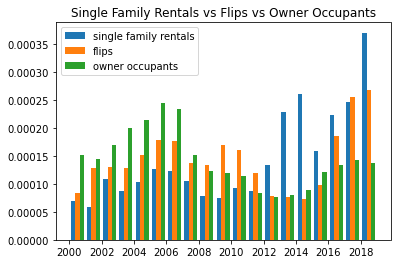

In [91]:
#plotting transactions by density
plt.title(label="Single Family Rentals vs Flips vs Owner Occupants")
plt.hist([investor_single_family_rentals_00_18['deed_date_dt_x'],investor_flips_00_18['deed_date_dt_x'],owner_occupants_00_18['deed_date_dt_x']],stacked=False, density=True, bins=19)
plt.legend(['single family rentals', 'flips', 'owner occupants'])

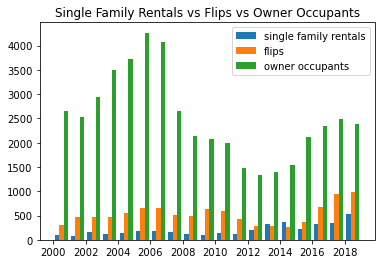

In [92]:
#plotting transactions by total value
plt.title(label="Single Family Rentals vs Flips vs Owner Occupants")
plt.hist([investor_single_family_rentals_00_18['deed_date_dt_x'],investor_flips_00_18['deed_date_dt_x'],owner_occupants_00_18['deed_date_dt_x']],stacked=False, density=False, bins=19)
plt.legend(['single family rentals', 'flips', 'owner occupants'])

In [93]:
institutional_investor_single_family_rentals = deeds[(deeds['classification'] == 'institutional investor rental')]
non_institutional_investor_single_family_rentals = deeds[(deeds['classification'] == 'non institutional investor rental')]

institutional_investor_single_family_rentals_00_18 = institutional_investor_single_family_rentals[institutional_investor_single_family_rentals['deed_date_dt_x'].dt.year <= 2018]
non_institutional_investor_single_family_rentals_00_18 = non_institutional_investor_single_family_rentals[non_institutional_investor_single_family_rentals['deed_date_dt_x'].dt.year <= 2018]

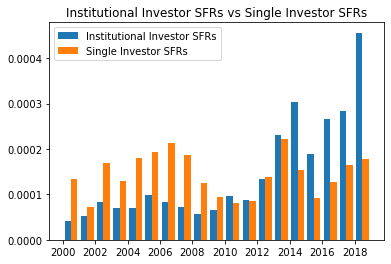

In [94]:
#investor breakdown by density
plt.title(label="Institutional Investor SFRs vs Single Investor SFRs")
plt.hist([institutional_investor_single_family_rentals_00_18['deed_date_dt_x'],non_institutional_investor_single_family_rentals_00_18['deed_date_dt_x']], stacked=False,density=True, bins=19)
plt.legend(['Institutional Investor SFRs', 'Single Investor SFRs'])

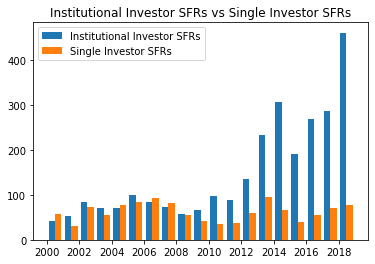

In [95]:
##investor breakdown by total
plt.title(label="Institutional Investor SFRs vs Single Investor SFRs")
plt.hist([institutional_investor_single_family_rentals_00_18['deed_date_dt_x'],non_institutional_investor_single_family_rentals_00_18['deed_date_dt_x']], stacked=False,density=False, bins=19)
plt.legend(['Institutional Investor SFRs', 'Single Investor SFRs'])

In [96]:
institutional_investor_flip = deeds[(deeds['classification'] == 'institutional investor flip')]
non_institutional_investor_flip = deeds[(deeds['classification'] == 'non institutional investor flip')]

institutional_investor_flip_00_18 = institutional_investor_flip[institutional_investor_flip['deed_date_dt_x'].dt.year <= 2018]
non_institutional_investor_flip_00_18 = non_institutional_investor_flip[non_institutional_investor_flip['deed_date_dt_x'].dt.year <= 2018]

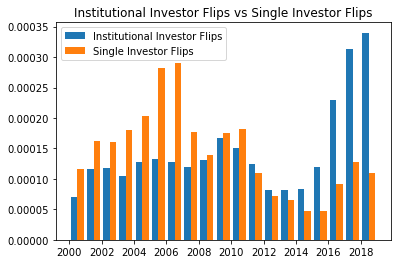

In [97]:
#investor breakdown by density
plt.title(label="Institutional Investor Flips vs Single Investor Flips")
plt.hist([institutional_investor_flip_00_18['deed_date_dt_x'],non_institutional_investor_flip_00_18['deed_date_dt_x']], stacked=False,density=True, bins=19)
plt.legend(['Institutional Investor Flips', 'Single Investor Flips'])

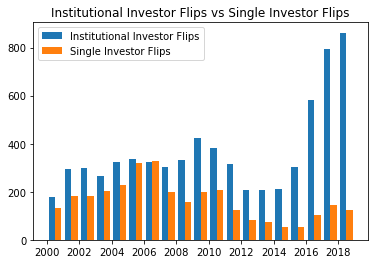

In [98]:
#investor breakdown by total
plt.title(label="Institutional Investor Flips vs Single Investor Flips")
plt.hist([institutional_investor_flip_00_18['deed_date_dt_x'],non_institutional_investor_flip_00_18['deed_date_dt_x']], stacked=False,density=False, bins=19)
plt.legend(['Institutional Investor Flips', 'Single Investor Flips'])

In [99]:
deeds.head()

,Unnamed: 0,Municipality,grantor_x,grantor_address,grantor_city_st_zip,grantee_x_x,grantee_address,grantee_city_st_zip,Property Location_x,Block,Lot,Qual,Property Class,Land Assmnt,Building Assmnt,Total Assmnt,Recorded Date,Deed Date,Book,Page,Sale Price,NU Code,Sq. Ft.,Cl. 4 Use,SR1A #,Yr. Built,StyDesc,Style,deed_date_cl,deed_date_dt_x,year,city,state,zip,RecordID,latitude_result,longitude_result,geometry,grantee_y,grantee,inv,occ,pub,grantor_y,grantee_x_y,deed_date_dt_y,Property Location_y,elapsed,elapsed_days,multi_invest,investor_all,owner_occup,Rank,own_period,classification
39122,39122,714,"DUNN, YARNICK",16 EASTERN PKWY,"HILLSIDE, NJ 00000","MARK, CURTIS",100 COLUMBIA AVE,"NEWARK, NJ 00000",100 COLUMBIA AVE,4032.00,69.00,NaN,2,0,0,0,12/22/06,8/31/06,12013,2112,320000.0,4.0,0.0,NaN,9111930.0,0.0,NaN,NaN,08/31/06,2006-08-31,2006.0,Newark,NJ,NaN,9111930.0,40.741497,-74.220240,POINT (569641.3505213677 695146.1121964357),False,False,0,1,0,"DUNN, YARNICK","MARK, CURTIS",2006-08-31,100 COLUMBIA AVE,13 days,13.0,1.0,1.0,0,1.0,999.0,non institutional investor rental
46429,46429,714,"REYNOLDS, LEONARDO",210 NORTH 9TH STREET,"NEWARK, NJ 00000","REYNOLDS, LEONARDO & AMANTINA",210 NORTH 9TH STREET,"NEWARK, NJ 00000",NORTH NINTH ST.,1945.01,25.00,NaN,2,84000,119500,203500,7/25/05,6/15/05,6212,294,1.0,1.0,2995.0,NaN,8604346.0,1952.0,NaN,NaN,06/15/05,2005-06-15,2005.0,Newark,NJ,NaN,8604346.0,40.760153,-74.190428,POINT (577877.6934047152 701970.0346963555),False,False,0,1,0,NaN,NaN,NaN,NaN,999 days,NaN,NaN,0.0,1,1.0,999.0,non investor
57744,57744,714,AARON JORDAN,1-8TH AVE,"NEWARK, NJ 00000","JORDAN, A.; L. KENERLY & D. MURPHY",1-8TH AVE,"NEWARK, NJ 00000",1 8TH AVE.,450.00,8.00,NaN,2,1300,5600,6900,1/28/03,1/3/02,5945,19,1.0,1.0,8716.0,NaN,7053068.0,1957.0,NaN,NaN,01/03/02,2002-01-03,2002.0,Newark,NJ,NaN,7053068.0,40.748870,-74.169055,POINT (583813.6133419409 697881.2633368543),False,False,0,1,0,NaN,NaN,NaN,NaN,999 days,NaN,NaN,0.0,1,1.0,999.0,non investor
8037,8037,714,THE KAMSON CORPORATION,270 SYLVAN AVENUE,"ENGLEWOOD CLIFFS, NJ 00000","FOREST HILLS 1, LLC,",110 CHESTNUT RIDGE RD 301,"MONTVALE, NJ 00000",1 BEAUMONT PL,785.01,1.03,C1G,2,142000,155500,297500,4/18/18,3/23/18,20180,33113,975456.0,NaN,0.0,0.0,5119549.0,0.0,NaN,NaN,03/23/18,2018-03-23,2018.0,Newark,NJ,NaN,5119549.0,40.779507,-74.171120,POINT (583199.7254384531 709040.2837734123),True,False,1,0,0,NaN,NaN,NaN,NaN,999 days,NaN,NaN,1.0,0,1.5,999.0,non investor
8038,8038,714,THE KAMSON CORPORATION,270 SYLVAN AVENUE,"ENGLEWOOD CLIFFS, NJ 00000","FOREST HILLS 1, LLC,",110 CHESTNUT RIDGE RD 301,"MONTVALE, NJ 00000",1 BEAUMONT PL,785.01,3.04,C3H,2,142000,133100,275100,4/18/18,3/23/18,20180,33115,913523.0,NaN,0.0,0.0,5119550.0,0.0,NaN,NaN,03/23/18,2018-03-23,2018.0,Newark,NJ,NaN,5119550.0,40.779507,-74.171120,POINT (583199.7254384531 709040.2837734123),True,False,1,0,0,NaN,NaN,NaN,NaN,999 days,NaN,NaN,1.0,0,1.5,0.0,institutional investor flip


In [100]:
deeds['geometry'] = deeds['geometry'].apply(wkt.loads)

In [101]:
deeds_classified = gpd.GeoDataFrame(deeds, geometry = deeds['geometry'], crs = 'epsg:3424')

In [102]:
# saving final list of grantees
deeds_classified.to_file("data/SR1A_deeds/deeds_investors_rentals_flips.geojson", driver = "GeoJSON")

## Reimport geojson of classified deeds

In [103]:
#read in classified deeds file
deeds_classified = gpd.read_file("data/SR1A_deeds/deeds_investors_rentals_flips.geojson")


In [104]:
deeds_classified['count_field'] = 1
deeds_classified['year'] = deeds_classified['year'].astype(str).replace('\.0', '', regex=True)

In [105]:
deeds_classified['institutional_investor_rental'] = np.where(deeds_classified['classification'].str.contains('institutional investor rental', regex=True),1, 0)
deeds_classified['non_institutional_investor_rental'] = np.where(deeds_classified['classification'].str.contains('non institutional investor rental', regex=True),1, 0)
deeds_classified['institutional_investor_flip'] = np.where(deeds_classified['classification'].str.contains('institutional investor flip', regex=True),1, 0)
deeds_classified['non_institutional_investor_flip'] = np.where(deeds_classified['classification'].str.contains('non institutional investor flip', regex=True),1, 0)
deeds_classified['non_investor'] = np.where(deeds_classified['classification'].str.contains('non investor', regex=True),1, 0)

In [106]:
deeds_classified.head()

,Unnamed: 0,Municipality,grantor_x,grantor_address,grantor_city_st_zip,grantee_x_x,grantee_address,grantee_city_st_zip,Property Location_x,Block,Lot,Qual,Property Class,Land Assmnt,Building Assmnt,Total Assmnt,Recorded Date,Deed Date,Book,Page,Sale Price,NU Code,Sq. Ft.,Cl. 4 Use,SR1A #,Yr. Built,StyDesc,Style,deed_date_cl,deed_date_dt_x,year,city,state,zip,RecordID,latitude_result,longitude_result,grantee_y,grantee,inv,occ,pub,grantor_y,grantee_x_y,deed_date_dt_y,Property Location_y,elapsed,elapsed_days,multi_invest,investor_all,owner_occup,Rank,own_period,classification,geometry,count_field,institutional_investor_rental,non_institutional_investor_rental,institutional_investor_flip,non_institutional_investor_flip,non_investor
0,39122,714,"DUNN, YARNICK",16 EASTERN PKWY,"HILLSIDE, NJ 00000","MARK, CURTIS",100 COLUMBIA AVE,"NEWARK, NJ 00000",100 COLUMBIA AVE,4032.00,69.00,None,2,0,0,0,12/22/06,8/31/06,12013,2112,320000.0,4.0,0.0,NaN,9111930.0,0.0,None,None,08/31/06,2006-08-31T00:00:00,2006,Newark,NJ,None,9111930.0,40.741497,-74.220240,False,False,0,1,0,"DUNN, YARNICK","MARK, CURTIS",2006-08-31,100 COLUMBIA AVE,13 days,13.0,1.0,1.0,0,1.0,999.0,non institutional investor rental,POINT (569641.351 695146.112),1,1,1,0,0,0
1,46429,714,"REYNOLDS, LEONARDO",210 NORTH 9TH STREET,"NEWARK, NJ 00000","REYNOLDS, LEONARDO & AMANTINA",210 NORTH 9TH STREET,"NEWARK, NJ 00000",NORTH NINTH ST.,1945.01,25.00,None,2,84000,119500,203500,7/25/05,6/15/05,6212,294,1.0,1.0,2995.0,NaN,8604346.0,1952.0,None,None,06/15/05,2005-06-15T00:00:00,2005,Newark,NJ,None,8604346.0,40.760153,-74.190428,False,False,0,1,0,None,None,None,None,999 days,NaN,NaN,0.0,1,1.0,999.0,non investor,POINT (577877.693 701970.035),1,0,0,0,0,1
2,57744,714,AARON JORDAN,1-8TH AVE,"NEWARK, NJ 00000","JORDAN, A.; L. KENERLY & D. MURPHY",1-8TH AVE,"NEWARK, NJ 00000",1 8TH AVE.,450.00,8.00,None,2,1300,5600,6900,1/28/03,1/3/02,5945,19,1.0,1.0,8716.0,NaN,7053068.0,1957.0,None,None,01/03/02,2002-01-03T00:00:00,2002,Newark,NJ,None,7053068.0,40.748870,-74.169055,False,False,0,1,0,None,None,None,None,999 days,NaN,NaN,0.0,1,1.0,999.0,non investor,POINT (583813.613 697881.263),1,0,0,0,0,1
3,8037,714,THE KAMSON CORPORATION,270 SYLVAN AVENUE,"ENGLEWOOD CLIFFS, NJ 00000","FOREST HILLS 1, LLC,",110 CHESTNUT RIDGE RD 301,"MONTVALE, NJ 00000",1 BEAUMONT PL,785.01,1.03,C1G,2,142000,155500,297500,4/18/18,3/23/18,20180,33113,975456.0,NaN,0.0,0.0,5119549.0,0.0,None,None,03/23/18,2018-03-23T00:00:00,2018,Newark,NJ,None,5119549.0,40.779507,-74.171120,True,False,1,0,0,None,None,None,None,999 days,NaN,NaN,1.0,0,1.5,999.0,non investor,POINT (583199.725 709040.284),1,0,0,0,0,1
4,8038,714,THE KAMSON CORPORATION,270 SYLVAN AVENUE,"ENGLEWOOD CLIFFS, NJ 00000","FOREST HILLS 1, LLC,",110 CHESTNUT RIDGE RD 301,"MONTVALE, NJ 00000",1 BEAUMONT PL,785.01,3.04,C3H,2,142000,133100,275100,4/18/18,3/23/18,20180,33115,913523.0,NaN,0.0,0.0,5119550.0,0.0,None,None,03/23/18,2018-03-23T00:00:00,2018,Newark,NJ,None,5119550.0,40.779507,-74.171120,True,False,1,0,0,None,None,None,None,999 days,NaN,NaN,1.0,0,1.5,0.0,institutional investor flip,POINT (583199.725 709040.284),1,0,0,1,0,0


In [107]:
all_properties = gpd.read_file("data/newark_zoning/Zoning.shp")

In [108]:
res_properties = all_properties[all_properties['PROPCLASS']=='2']

In [109]:
res_properties = res_properties.to_crs('epsg:3424')

In [110]:
res_properties.head()

,OBJECTID,ID,MUN,BLOCK,LOT,QCODE,BLOCK_LOT,PAMS_PIN,AREA,PERIMETER,EASTING,NORTHING,LASTUPDATE,Geometry_A,Geometry_P,ID_1,CTYDSTNO,BLOCKNO,LOTNO,QUALNO,ADDLOTS,PROPLOC,LANDDESC,BUILDDESC,ACREAGE,PROPCLASS,ZONING,OWNERSNAME,OWNERADD1,OWNERADD2,ZIPCODE,LASTUPDA_1,DEEDBOOK,DEEDPAGE,SALESDATE,SALESPRICE,TAXACCT,BANKCODE,LANDVALUE,IMPRVALUE,NETVALUE,LSTYRTAX,FACILITY,STATUTE,CITYWARD,SPECTAXDIS,OLDBLOCKNO,OLDLOTNO,OLDQUALCOD,PAMS_PIN_1,Shape_STAr,Shape_STLe,OBJECTID_2,ZONINGCODE,RDV_AREA,HISTORIC_D,Shape_Leng,Shape_Area,geometry
40,2279,34246.0,0714,2828,61,None,2828-61,0714_2828_61,1004.0,127.0,581948.044,696581.413,2015-01-15,1004.282920,126.880960,34762.0,0714,2828.0,61.0,None,None,8 SUMMIT ST,32.5X30.8 AVG.,2SF,0.02,2,RDV,KILLEN LUCY,8 SUMMIT ST,"NEWARK, NJ",07103.3910,2014-10-25,4669,767,1980-01-21,7500.0,None,0,19700,89300,109000,3380.09,None,None,CW,None,None,None,None,0714_2828_61,1004.277740,126.881205,0,RDV,Broad Street Station,James Street,126.881205,1004.277747,"POLYGON ((581927.542 696572.342, 581943.604 69..."
45,2346,34236.0,0714,2828,49,None,2828-49,0714_2828_49,2065.0,288.0,581863.476,696393.908,2015-01-15,2065.023512,288.483877,34764.0,0714,2828.0,49.0,None,None,22- SUMMIT ST,16.1X127,2SB,0.04,2,RDV,WILLIAMS SARAH,22 SUMMIT ST,"NEWARK, NJ",07103.3910,2014-10-25,4492,131,1974-12-05,1900.0,None,0,41800,60500,102300,3172.32,None,None,CW,None,None,None,None,0714_2828_49,2065.033144,288.484030,0,RDV,Broad Street Station,James Street,288.484030,2065.033220,"POLYGON ((581831.966 696403.200, 581839.900 69..."
46,2349,34235.0,0714,2828,48,None,2828-48,0714_2828_48,2090.0,292.0,581855.877,696380.562,2015-01-15,2090.257864,292.343343,34765.0,0714,2828.0,48.0,None,None,24 SUMMIT ST,16X129 AVG.,2SB,0.04,2,RDV,ANDERSON ROBERT L. & MILDRED L.,24 SUMMIT ST,"NEWARK, NJ",07103.3910,2014-10-25,4429,999,1972-12-06,10000.0,None,0,41800,59500,101300,3141.31,None,None,CW,None,None,None,None,0714_2828_48,2090.230010,292.342777,0,RDV,Broad Street Station,James Street,292.342777,2090.229977,"POLYGON ((581824.059 696389.207, 581831.966 69..."
47,2355,34234.0,0714,2828,47,None,2828-47,0714_2828_47,2122.0,296.0,581847.714,696366.582,2015-01-15,2121.770446,296.302093,34748.0,0714,2828.0,47.0,None,None,24- SUMMIT ST,16X131.2,2SB,0.04,2,RDV,"SWEENEY, ROBERT",24A SUMMIT ST,"NEWARK, NJ",07103.3911,2014-10-31,5742,157,2000-12-08,87000.0,None,660,42600,46100,88700,2750.59,None,None,CW,None,None,None,None,0714_2828_47,2121.785371,296.302424,0,RDV,Broad Street Station,James Street,296.302424,2121.785416,"POLYGON ((581816.154 696375.217, 581824.059 69..."
48,2358,34233.0,0714,2828,46,None,2828-46,0714_2828_46,2147.0,300.0,581839.623,696352.157,2015-01-15,2146.574905,300.162526,34750.0,0714,2828.0,46.0,None,None,26 SUMMIT ST,16X133,None,0.04,2,RDV,"BUDDY, CONSTANCE",28 SUMMIT ST,"NEWARK, NJ",07103.3910,2014-10-18,5692,806,2000-04-17,0.0,None,0,42600,64600,107200,3324.27,None,None,CW,None,None,None,None,0714_2828_46,2146.585205,300.163047,0,RDV,Broad Street Station,James Street,300.163047,2146.585224,"POLYGON ((581808.277 696361.276, 581816.154 69..."


In [111]:
res_properties_counts = res_properties[['OBJECTID', 'geometry']]

In [112]:
res_properties_counts = res_properties_counts.rename(columns = {'OBJECTID':'res_parcel_num'})

In [113]:
tracts = gpd.read_file('data/newark_tracts/newarktractpolygon.geojson')

In [114]:
blocks = gpd.read_file('data/NEWARK/Census_Geographies.geojson')

In [115]:
wards = gpd.read_file('data/newark_wards/Wards_2012.shp')

In [116]:
blocks = blocks.to_crs('epsg:3424')

In [117]:
#reprojecting tracts
tracts = tracts.to_crs('epsg:3424')

In [118]:
#reprojecting wards
wards = wards.to_crs('epsg:3424')

## Spatial Join between Deeds and Wards

In [122]:
deeds_blocks = gpd.sjoin(blocks, deeds_classified, how='left', op='intersects').reset_index()

In [123]:
#getting counts of purchases by type for year block for each year

grouped_deeds = deeds_blocks.groupby(['GEOID', 'year']).agg({'institutional_investor_rental':'sum',
                                                        'non_institutional_investor_rental':'sum',
                                                        'institutional_investor_flip':'sum', 'non_institutional_investor_flip':'sum',
                                                        'non_investor':'sum','count_field':'count'}).unstack()

In [124]:
# unstacking the grouped columns
new_cols = [''.join(t) for t in grouped_deeds.columns]
grouped_deeds.columns = new_cols

In [125]:
grouped_deeds.head()

,institutional_investor_rental2000,institutional_investor_rental2001,institutional_investor_rental2002,institutional_investor_rental2003,institutional_investor_rental2004,institutional_investor_rental2005,institutional_investor_rental2006,institutional_investor_rental2007,institutional_investor_rental2008,institutional_investor_rental2009,institutional_investor_rental2010,institutional_investor_rental2011,institutional_investor_rental2012,institutional_investor_rental2013,institutional_investor_rental2014,institutional_investor_rental2015,institutional_investor_rental2016,institutional_investor_rental2017,institutional_investor_rental2018,institutional_investor_rental2019,institutional_investor_rental2020,non_institutional_investor_rental2000,non_institutional_investor_rental2001,non_institutional_investor_rental2002,non_institutional_investor_rental2003,non_institutional_investor_rental2004,non_institutional_investor_rental2005,non_institutional_investor_rental2006,non_institutional_investor_rental2007,non_institutional_investor_rental2008,non_institutional_investor_rental2009,non_institutional_investor_rental2010,non_institutional_investor_rental2011,non_institutional_investor_rental2012,non_institutional_investor_rental2013,non_institutional_investor_rental2014,non_institutional_investor_rental2015,non_institutional_investor_rental2016,non_institutional_investor_rental2017,non_institutional_investor_rental2018,non_institutional_investor_rental2019,non_institutional_investor_rental2020,institutional_investor_flip2000,institutional_investor_flip2001,institutional_investor_flip2002,institutional_investor_flip2003,institutional_investor_flip2004,institutional_investor_flip2005,institutional_investor_flip2006,institutional_investor_flip2007,...,non_institutional_investor_flip2013,non_institutional_investor_flip2014,non_institutional_investor_flip2015,non_institutional_investor_flip2016,non_institutional_investor_flip2017,non_institutional_investor_flip2018,non_institutional_investor_flip2019,non_institutional_investor_flip2020,non_investor2000,non_investor2001,non_investor2002,non_investor2003,non_investor2004,non_investor2005,non_investor2006,non_investor2007,non_investor2008,non_investor2009,non_investor2010,non_investor2011,non_investor2012,non_investor2013,non_investor2014,non_investor2015,non_investor2016,non_investor2017,non_investor2018,non_investor2019,non_investor2020,count_field2000,count_field2001,count_field2002,count_field2003,count_field2004,count_field2005,count_field2006,count_field2007,count_field2008,count_field2009,count_field2010,count_field2011,count_field2012,count_field2013,count_field2014,count_field2015,count_field2016,count_field2017,count_field2018,count_field2019,count_field2020
GEOID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
340130001001000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,3.0,3.0,1.0,4.0,1.0,2.0,2.0,1.0,1.0,NaN,1.0,NaN,1.0,1.0,NaN,4.0,1.0,3.0,1.0,NaN,1.0,5.0,3.0,2.0,4.0,1.0,2.0,2.0,1.0,1.0,NaN,1.0,NaN,1.0,1.0,NaN,4.0,1.0,3.0,1.0,NaN,1.0
340130001001001,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,NaN,1.0,NaN,NaN,NaN,0.0,1.0,NaN,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0,...,NaN,0.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,1.0,1.0,3.0,NaN,1.0,1.0,1.0,NaN,NaN,NaN,NaN,2.0,NaN,0.0,NaN,NaN,NaN,1.0,3.0,NaN,NaN,3.0,1.0,3.0,NaN,1.0,1.0,1.0,NaN,NaN,NaN,NaN,2.0,NaN,1.0,NaN,NaN,NaN,1.0,4.0,NaN
340130001001002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN,1.0,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN,1.0,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN,...,NaN,NaN,0.0,0.0,NaN,0.0,0.0,NaN,1.0,4.0,3.0,2.0,7.0,2.0,5.0,NaN,3.0,NaN,NaN,1.0

In [126]:
block_geometry = blocks[['GEOID', 'geometry']]

In [127]:
#merging groupd blocks with geometry field
grouped_deeds = block_geometry.merge(grouped_deeds, how='left', left_on="GEOID", right_on="GEOID")

#converting to a geodataframe
grouped_deeds = gpd.GeoDataFrame(grouped_deeds, geometry = grouped_deeds['geometry'])


In [128]:
# joining residential parcels from Lot Area to tracts to have count of parcels
res_blocks = gpd.sjoin(blocks, res_properties_counts, how='left', op='intersects').reset_index()

In [129]:
res_count = res_blocks.groupby(['GEOID']).agg({'res_parcel_num':'count'}).reset_index()

In [130]:
grouped_deeds = grouped_deeds.merge(res_count, how="left", left_on='GEOID', right_on='GEOID')

## Calculating percent by classification purchases per tract per year

In [131]:
# percent of purchases by block that are institutional investor purchases for rentals
#2000
grouped_deeds['per_inst_inv_2000'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_rental2000']/x['res_parcel_num'], axis=1)
# 2001
grouped_deeds['per_inst_inv_2001'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_rental2001']/x['res_parcel_num'], axis=1)
# 2002
grouped_deeds['per_inst_inv_2002'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_rental2002']/x['res_parcel_num'], axis=1)
# 2003
grouped_deeds['per_inst_inv_2003'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_rental2003']/x['res_parcel_num'], axis=1)
# 2004
grouped_deeds['per_inst_inv_2004'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_rental2004']/x['res_parcel_num'], axis=1)
# 2005
grouped_deeds['per_inst_inv_2005'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_rental2005']/x['res_parcel_num'], axis=1)
# percent of purchases by block that are investor purchases 2006
grouped_deeds['per_inst_inv_2006'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_rental2006']/x['res_parcel_num'], axis=1)
# 2007
grouped_deeds['per_inst_inv_2007'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_rental2007']/x['res_parcel_num'], axis=1)
# 2008
grouped_deeds['per_inst_inv_2008'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_rental2008']/x['res_parcel_num'], axis=1)
# 2009
grouped_deeds['per_inst_inv_2009'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_rental2009']/x['res_parcel_num'], axis=1)
# 2010
grouped_deeds['per_inst_inv_2010'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_rental2010']/x['res_parcel_num'], axis=1)
# 2011
grouped_deeds['per_inst_inv_2011'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_rental2011']/x['res_parcel_num'], axis=1)
# percent of purchases by block that are investor purchases 2012
grouped_deeds['per_inst_inv_2012'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_rental2012']/x['res_parcel_num'], axis=1)
# 2013
grouped_deeds['per_inst_inv_2013'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_rental2013']/x['res_parcel_num'], axis=1)
# 2014
grouped_deeds['per_inst_inv_2014'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_rental2014']/x['res_parcel_num'], axis=1)
# 2015
grouped_deeds['per_inst_inv_2015'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_rental2015']/x['res_parcel_num'], axis=1)
# 2016
grouped_deeds['per_inst_inv_2016'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_rental2016']/x['res_parcel_num'], axis=1)
# 2017
grouped_deeds['per_inst_inv_2017'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_rental2017']/x['res_parcel_num'], axis=1)
# percent of purchases by block that are investor purchases 2018
grouped_deeds['per_inst_inv_2018'] = grouped_deeds.apply(
    lambda x:0 if x['res_parcel_num'] == 0 else x['institutional_investor_rental2018']/x['res_parcel_num'], axis=1)

### non institutional investor rentals

In [132]:
# percent of purchases by block that are non-institutional investor purchases for rentals
#2000
grouped_deeds['per_non_inst_inv_2000'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_rental2000']/x['res_parcel_num'], axis=1)
# 2001
grouped_deeds['per_non_inst_inv_2001'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_rental2001']/x['res_parcel_num'], axis=1)
# 2002
grouped_deeds['per_non_inst_inv_2002'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_rental2002']/x['res_parcel_num'], axis=1)
# 2003
grouped_deeds['per_non_inst_inv_2003'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_rental2003']/x['res_parcel_num'], axis=1)
# 2004
grouped_deeds['per_non_inst_inv_2004'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_rental2004']/x['res_parcel_num'], axis=1)
# 2005
grouped_deeds['per_non_inst_inv_2005'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_rental2005']/x['res_parcel_num'], axis=1)
# percent of purchases by block that are investor purchases 2006
grouped_deeds['per_non_inst_inv_2006'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_rental2006']/x['res_parcel_num'], axis=1)
# 2007
grouped_deeds['per_non_inst_inv_2007'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_rental2007']/x['res_parcel_num'], axis=1)
# 2008
grouped_deeds['per_non_inst_inv_2008'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_rental2008']/x['res_parcel_num'], axis=1)
# 2009
grouped_deeds['per_non_inst_inv_2009'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_rental2009']/x['res_parcel_num'], axis=1)
# 2010
grouped_deeds['per_non_inst_inv_2010'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_rental2010']/x['res_parcel_num'], axis=1)
# 2011
grouped_deeds['per_non_inst_inv_2011'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_rental2011']/x['res_parcel_num'], axis=1)
# percent of purchases by block that are investor purchases 2012
grouped_deeds['per_non_inst_inv_2012'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_rental2012']/x['res_parcel_num'], axis=1)
# 2013
grouped_deeds['per_non_inst_inv_2013'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_rental2013']/x['res_parcel_num'], axis=1)
# 2014
grouped_deeds['per_non_inst_inv_2014'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_rental2014']/x['res_parcel_num'], axis=1)
# 2015
grouped_deeds['per_non_inst_inv_2015'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_rental2015']/x['res_parcel_num'], axis=1)
# 2016
grouped_deeds['per_non_inst_inv_2016'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_rental2016']/x['res_parcel_num'], axis=1)
# 2017
grouped_deeds['per_non_inst_inv_2017'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_rental2017']/x['res_parcel_num'], axis=1)
# percent of purchases by block that are investor purchases 2018
grouped_deeds['per_non_inst_inv_2018'] = grouped_deeds.apply(
    lambda x:0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_rental2018']/x['res_parcel_num'], axis=1)

### institutional investor flip

In [133]:
# percent of purchases by block that are institutional investor purchases for flip
#2000
grouped_deeds['per_inst_inv_flip_2000'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_flip2000']/x['res_parcel_num'], axis=1)
# 2001
grouped_deeds['per_inst_inv_flip_2001'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_flip2001']/x['res_parcel_num'], axis=1)
# 2002
grouped_deeds['per_inst_inv_flip_2002'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_flip2002']/x['res_parcel_num'], axis=1)
# 2003
grouped_deeds['per_inst_inv_flip_2003'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_flip2003']/x['res_parcel_num'], axis=1)
# 2004
grouped_deeds['per_inst_inv_flip_2004'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_flip2004']/x['res_parcel_num'], axis=1)
# 2005
grouped_deeds['per_inst_inv_flip_2005'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_flip2005']/x['res_parcel_num'], axis=1)
# percent of purchases by block that are investor purchases 2006
grouped_deeds['per_inst_inv_flip_2006'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_flip2006']/x['res_parcel_num'], axis=1)
# 2007
grouped_deeds['per_inst_inv_flip_2007'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_flip2007']/x['res_parcel_num'], axis=1)
# 2008
grouped_deeds['per_inst_inv_flip_2008'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_flip2008']/x['res_parcel_num'], axis=1)
# 2009
grouped_deeds['per_inst_inv_flip_2009'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_flip2009']/x['res_parcel_num'], axis=1)
# 2010
grouped_deeds['per_inst_inv_flip_2010'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_flip2010']/x['res_parcel_num'], axis=1)
# 2011
grouped_deeds['per_inst_inv_flip_2011'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_flip2011']/x['res_parcel_num'], axis=1)
# percent of purchases by block that are investor purchases 2012
grouped_deeds['per_inst_inv_flip_2012'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_flip2012']/x['res_parcel_num'], axis=1)
# 2013
grouped_deeds['per_inst_inv_flip_2013'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_flip2013']/x['res_parcel_num'], axis=1)
# 2014
grouped_deeds['per_inst_inv_flip_2014'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_flip2014']/x['res_parcel_num'], axis=1)
# 2015
grouped_deeds['per_inst_inv_flip_2015'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_flip2015']/x['res_parcel_num'], axis=1)
# 2016
grouped_deeds['per_inst_inv_flip_2016'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_flip2016']/x['res_parcel_num'], axis=1)
# 2017
grouped_deeds['per_inst_inv_flip_2017'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['institutional_investor_flip2017']/x['res_parcel_num'], axis=1)
# percent of purchases by block that are investor purchases 2018
grouped_deeds['per_inst_inv_flip_2018'] = grouped_deeds.apply(
    lambda x:0 if x['res_parcel_num'] == 0 else x['institutional_investor_flip2018']/x['res_parcel_num'], axis=1)

### non institutional investor flip

In [134]:
# percent of purchases by block that are non-institutional investor purchases for flip
#2000
grouped_deeds['per_non_inst_inv_flip_2000'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_flip2000']/x['res_parcel_num'], axis=1)
# 2001
grouped_deeds['per_non_inst_inv_flip_2001'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_flip2001']/x['res_parcel_num'], axis=1)
# 2002
grouped_deeds['per_non_inst_inv_flip_2002'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_flip2002']/x['res_parcel_num'], axis=1)
# 2003
grouped_deeds['per_non_inst_inv_flip_2003'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_flip2003']/x['res_parcel_num'], axis=1)
# 2004
grouped_deeds['per_non_inst_inv_flip_2004'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_flip2004']/x['res_parcel_num'], axis=1)
# 2005
grouped_deeds['per_non_inst_inv_flip_2005'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_flip2005']/x['res_parcel_num'], axis=1)
# percent of purchases by block that are investor purchases 2006
grouped_deeds['per_non_inst_inv_flip_2006'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_flip2006']/x['res_parcel_num'], axis=1)
# 2007
grouped_deeds['per_non_inst_inv_flip_2007'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_flip2007']/x['res_parcel_num'], axis=1)
# 2008
grouped_deeds['per_non_inst_inv_flip_2008'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_flip2008']/x['res_parcel_num'], axis=1)
# 2009
grouped_deeds['per_non_inst_inv_flip_2009'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_flip2009']/x['res_parcel_num'], axis=1)
# 2010
grouped_deeds['per_non_inst_inv_flip_2010'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_flip2010']/x['res_parcel_num'], axis=1)
# 2011
grouped_deeds['per_non_inst_inv_flip_2011'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_flip2011']/x['res_parcel_num'], axis=1)
# percent of purchases by block that are investor purchases 2012
grouped_deeds['per_non_inst_inv_flip_2012'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_flip2012']/x['res_parcel_num'], axis=1)
# 2013
grouped_deeds['per_non_inst_inv_flip_2013'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_flip2013']/x['res_parcel_num'], axis=1)
# 2014
grouped_deeds['per_non_inst_inv_flip_2014'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_flip2014']/x['res_parcel_num'], axis=1)
# 2015
grouped_deeds['per_non_inst_inv_flip_2015'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_flip2015']/x['res_parcel_num'], axis=1)
# 2016
grouped_deeds['per_non_inst_inv_flip_2016'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_flip2016']/x['res_parcel_num'], axis=1)
# 2017
grouped_deeds['per_non_inst_inv_flip_2017'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_flip2017']/x['res_parcel_num'], axis=1)
# percent of purchases by block that are investor purchases 2018
grouped_deeds['per_non_inst_inv_flip_2018'] = grouped_deeds.apply(
    lambda x:0 if x['res_parcel_num'] == 0 else x['non_institutional_investor_flip2018']/x['res_parcel_num'], axis=1)

### percent non investor/owner occupied

In [135]:
# percent of purchases by block that are non-investor purchases for owner occupation
#2000
grouped_deeds['per_non_inv_2000'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_investor2000']/x['res_parcel_num'], axis=1)
# 2001
grouped_deeds['per_non_inv_2001'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_investor2001']/x['res_parcel_num'], axis=1)
# 2002
grouped_deeds['per_non_inv_2002'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_investor2002']/x['res_parcel_num'], axis=1)
# 2003
grouped_deeds['per_non_inv_2003'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_investor2003']/x['res_parcel_num'], axis=1)
# 2004
grouped_deeds['per_non_inv_2004'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_investor2004']/x['res_parcel_num'], axis=1)
# 2005
grouped_deeds['per_non_inv_2005'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_investor2005']/x['res_parcel_num'], axis=1)
# percent of purchases by block that are investor purchases 2006
grouped_deeds['per_non_inv_2006'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_investor2006']/x['res_parcel_num'], axis=1)
# 2007
grouped_deeds['per_non_inv_2007'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_investor2007']/x['res_parcel_num'], axis=1)
# 2008
grouped_deeds['per_non_inv_2008'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_investor2008']/x['res_parcel_num'], axis=1)
# 2009
grouped_deeds['per_non_inv_2009'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_investor2009']/x['res_parcel_num'], axis=1)
# 2010
grouped_deeds['per_non_inv_2010'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_investor2010']/x['res_parcel_num'], axis=1)
# 2011
grouped_deeds['per_non_inv_2011'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_investor2011']/x['res_parcel_num'], axis=1)
# percent of purchases by block that are investor purchases 2012
grouped_deeds['per_non_inv_2012'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_investor2012']/x['res_parcel_num'], axis=1)
# 2013
grouped_deeds['per_non_inv_2013'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_investor2013']/x['res_parcel_num'], axis=1)
# 2014
grouped_deeds['per_non_inv_2014'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_investor2014']/x['res_parcel_num'], axis=1)
# 2015
grouped_deeds['per_non_inv_2015'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_investor2015']/x['res_parcel_num'], axis=1)
# 2016
grouped_deeds['per_non_inv_2016'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_investor2016']/x['res_parcel_num'], axis=1)
# 2017
grouped_deeds['per_non_inv_2017'] = grouped_deeds.apply(
    lambda x: 0 if x['res_parcel_num'] == 0 else x['non_investor2017']/x['res_parcel_num'], axis=1)
# percent of purchases by block that are investor purchases 2018
grouped_deeds['per_non_inv_2018'] = grouped_deeds.apply(
    lambda x:0 if x['res_parcel_num'] == 0 else x['non_investor2018']/x['res_parcel_num'], axis=1)

In [136]:
# list comprehension to be able to fill all NaN values with 0 so that morans i will work
var = [i for i in grouped_deeds.columns]


var.remove('geometry')

In [137]:
grouped_deeds = grouped_deeds.fillna({f:0 for f in var})

In [138]:
##saving grouped deeds as checkpoint
grouped_deeds.to_file('data/PROCESSED/grouped_deeds_tracts.geojson',driver="GeoJSON")

In [139]:
## can read grouped deeds in from here.....
grouped_deeds = gpd.read_file('data/PROCESSED/grouped_deeds_tracts.geojson')

In [140]:
from pysal.lib.weights import DistanceBand
from pysal.explore.esda.moran import Moran

In [141]:
# creating spatial weight for tracts
#  distance band with threshold of 1/2 mile
#  uses a binary method so everything within 1/2 mile gets weighted equally and 
# everything outside is considered not related/not a neighbor 
weight = DistanceBand.from_dataframe(grouped_deeds, threshold=2640)

C:\Users\dmcna\anaconda3\envs\geo-2021\lib\site-packages\pysal\lib\weights\weights.py:168: UserWarning: There are 2 disconnected observations 
  Island ids: 599, 1781
  " Island ids: %s" % ', '.join(str(island) for island in self.islands))


## Global Moran

In [142]:
## 2000-2010
global_moran_inst_rent = Moran.by_col(grouped_deeds,
       ['per_inst_inv_2000','per_inst_inv_2001','per_inst_inv_2002',
       'per_inst_inv_2003','per_inst_inv_2004','per_inst_inv_2005',
       'per_inst_inv_2006','per_inst_inv_2007','per_inst_inv_2008',
       'per_inst_inv_2009','per_inst_inv_2010','per_inst_inv_2011','per_inst_inv_2012',
       'per_inst_inv_2013','per_inst_inv_2014','per_inst_inv_2015',
       'per_inst_inv_2016','per_inst_inv_2017','per_inst_inv_2018'],w=weight, inplace=False)
global_moran_non_inst_rent = Moran.by_col(grouped_deeds,
       ['per_non_inst_inv_2000','per_non_inst_inv_2001','per_non_inst_inv_2002',
       'per_non_inst_inv_2003','per_non_inst_inv_2004','per_non_inst_inv_2005',
       'per_non_inst_inv_2006','per_non_inst_inv_2007','per_non_inst_inv_2008',
       'per_non_inst_inv_2009','per_non_inst_inv_2010','per_non_inst_inv_2011','per_non_inst_inv_2012',
       'per_non_inst_inv_2013','per_non_inst_inv_2014','per_non_inst_inv_2015',
       'per_non_inst_inv_2016','per_non_inst_inv_2017','per_non_inst_inv_2018'],w=weight, inplace=False)
global_moran_inst_flip = Moran.by_col(grouped_deeds,
       ['per_inst_inv_flip_2000','per_inst_inv_flip_2001','per_inst_inv_flip_2002',
       'per_inst_inv_flip_2003','per_inst_inv_flip_2004','per_inst_inv_flip_2005',
       'per_inst_inv_flip_2006','per_inst_inv_flip_2007','per_inst_inv_flip_2008',
       'per_inst_inv_flip_2009','per_inst_inv_flip_2010','per_inst_inv_flip_2011','per_inst_inv_flip_2012',
       'per_inst_inv_flip_2013','per_inst_inv_flip_2014','per_inst_inv_flip_2015',
       'per_inst_inv_flip_2016','per_inst_inv_flip_2017','per_inst_inv_flip_2018'],w=weight, inplace=False)
global_moran_non_inst_flip = Moran.by_col(grouped_deeds,
       ['per_non_inst_inv_flip_2000','per_non_inst_inv_flip_2001','per_non_inst_inv_flip_2002',
       'per_non_inst_inv_flip_2003','per_non_inst_inv_flip_2004','per_non_inst_inv_flip_2005',
       'per_non_inst_inv_flip_2006','per_non_inst_inv_flip_2007','per_non_inst_inv_flip_2008',
       'per_non_inst_inv_flip_2009', 'per_non_inst_inv_flip_2010','per_non_inst_inv_flip_2011','per_non_inst_inv_flip_2012',
       'per_non_inst_inv_flip_2013','per_non_inst_inv_flip_2014','per_non_inst_inv_flip_2015',
       'per_non_inst_inv_flip_2016','per_non_inst_inv_flip_2017','per_non_inst_inv_flip_2018'],w=weight, inplace=False)
global_moran_non_inv = Moran.by_col(grouped_deeds,
       ['per_non_inv_2000','per_non_inv_2001','per_non_inv_2002',
       'per_non_inv_2003','per_non_inv_2004','per_non_inv_2005',
       'per_non_inv_2006','per_non_inv_2007','per_non_inv_2008',
       'per_non_inv_2009','per_non_inv_2010','per_non_inv_2011','per_non_inv_2012',
       'per_non_inv_2013','per_non_inv_2014','per_non_inv_2015',
       'per_non_inv_2016','per_non_inv_2017','per_non_inv_2018'],w=weight, inplace=False)

('WARNING: ', 599, ' is an island (no neighbors)')
('WARNING: ', 1781, ' is an island (no neighbors)')


In [143]:
# formatting results into a single table with global moran's results for each year
keep_inst_rent = ['per_inst_inv_2000_moran', 'per_inst_inv_2000_p_sim',
       'per_inst_inv_2001_moran', 'per_inst_inv_2001_p_sim', 'per_inst_inv_2002_moran',
       'per_inst_inv_2002_p_sim', 'per_inst_inv_2003_moran', 'per_inst_inv_2003_p_sim',
       'per_inst_inv_2004_moran', 'per_inst_inv_2004_p_sim', 'per_inst_inv_2005_moran',
       'per_inst_inv_2005_p_sim', 'per_inst_inv_2006_moran', 'per_inst_inv_2006_p_sim',
       'per_inst_inv_2007_moran', 'per_inst_inv_2007_p_sim', 'per_inst_inv_2008_moran',
       'per_inst_inv_2008_p_sim', 'per_inst_inv_2009_moran', 'per_inst_inv_2009_p_sim','per_inst_inv_2010_moran', 'per_inst_inv_2010_p_sim',
       'per_inst_inv_2011_moran', 'per_inst_inv_2011_p_sim', 'per_inst_inv_2012_moran',
       'per_inst_inv_2012_p_sim', 'per_inst_inv_2013_moran', 'per_inst_inv_2013_p_sim',
       'per_inst_inv_2014_moran', 'per_inst_inv_2014_p_sim', 'per_inst_inv_2015_moran',
       'per_inst_inv_2015_p_sim', 'per_inst_inv_2016_moran', 'per_inst_inv_2016_p_sim',
       'per_inst_inv_2017_moran', 'per_inst_inv_2017_p_sim', 'per_inst_inv_2018_moran',
       'per_inst_inv_2018_p_sim']
keep_non_inst_rent = ['per_non_inst_inv_2000_moran', 'per_non_inst_inv_2000_p_sim',
       'per_non_inst_inv_2001_moran', 'per_non_inst_inv_2001_p_sim', 'per_non_inst_inv_2002_moran',
       'per_non_inst_inv_2002_p_sim', 'per_non_inst_inv_2003_moran', 'per_non_inst_inv_2003_p_sim',
       'per_non_inst_inv_2004_moran', 'per_non_inst_inv_2004_p_sim', 'per_non_inst_inv_2005_moran',
       'per_non_inst_inv_2005_p_sim', 'per_non_inst_inv_2006_moran', 'per_non_inst_inv_2006_p_sim',
       'per_non_inst_inv_2007_moran', 'per_non_inst_inv_2007_p_sim', 'per_non_inst_inv_2008_moran',
       'per_non_inst_inv_2008_p_sim', 'per_non_inst_inv_2009_moran', 'per_non_inst_inv_2009_p_sim','per_non_inst_inv_2010_moran', 'per_non_inst_inv_2010_p_sim',
       'per_non_inst_inv_2011_moran', 'per_non_inst_inv_2011_p_sim', 'per_non_inst_inv_2012_moran',
       'per_non_inst_inv_2012_p_sim', 'per_non_inst_inv_2013_moran', 'per_non_inst_inv_2013_p_sim',
       'per_non_inst_inv_2014_moran', 'per_non_inst_inv_2014_p_sim', 'per_non_inst_inv_2015_moran',
       'per_non_inst_inv_2015_p_sim', 'per_non_inst_inv_2016_moran', 'per_non_inst_inv_2016_p_sim',
       'per_non_inst_inv_2017_moran', 'per_non_inst_inv_2017_p_sim', 'per_non_inst_inv_2018_moran',
       'per_non_inst_inv_2018_p_sim']
keep_inst_flip = ['per_inst_inv_flip_2000_moran', 'per_inst_inv_flip_2000_p_sim',
       'per_inst_inv_flip_2001_moran', 'per_inst_inv_flip_2001_p_sim', 'per_inst_inv_flip_2002_moran',
       'per_inst_inv_flip_2002_p_sim', 'per_inst_inv_flip_2003_moran', 'per_inst_inv_flip_2003_p_sim',
       'per_inst_inv_flip_2004_moran', 'per_inst_inv_flip_2004_p_sim', 'per_inst_inv_flip_2005_moran',
       'per_inst_inv_flip_2005_p_sim', 'per_inst_inv_flip_2006_moran', 'per_inst_inv_flip_2006_p_sim',
       'per_inst_inv_flip_2007_moran', 'per_inst_inv_flip_2007_p_sim', 'per_inst_inv_flip_2008_moran',
       'per_inst_inv_flip_2008_p_sim', 'per_inst_inv_flip_2009_moran', 'per_inst_inv_flip_2009_p_sim','per_inst_inv_flip_2010_moran', 'per_inst_inv_flip_2010_p_sim',
       'per_inst_inv_flip_2011_moran', 'per_inst_inv_flip_2011_p_sim', 'per_inst_inv_flip_2012_moran',
       'per_inst_inv_flip_2012_p_sim', 'per_inst_inv_flip_2013_moran', 'per_inst_inv_flip_2013_p_sim',
       'per_inst_inv_flip_2014_moran', 'per_inst_inv_flip_2014_p_sim', 'per_inst_inv_flip_2015_moran',
       'per_inst_inv_flip_2015_p_sim', 'per_inst_inv_flip_2016_moran', 'per_inst_inv_flip_2016_p_sim',
       'per_inst_inv_flip_2017_moran', 'per_inst_inv_flip_2017_p_sim', 'per_inst_inv_flip_2018_moran',
       'per_inst_inv_flip_2018_p_sim']
keep_non_inst_flip = ['per_non_inst_inv_flip_2000_moran', 'per_non_inst_inv_flip_2000_p_sim',
       'per_non_inst_inv_flip_2001_moran', 'per_non_inst_inv_flip_2001_p_sim', 'per_non_inst_inv_flip_2002_moran',
       'per_non_inst_inv_flip_2002_p_sim', 'per_non_inst_inv_flip_2003_moran', 'per_non_inst_inv_flip_2003_p_sim',
       'per_non_inst_inv_flip_2004_moran', 'per_non_inst_inv_flip_2004_p_sim', 'per_non_inst_inv_flip_2005_moran',
       'per_non_inst_inv_flip_2005_p_sim', 'per_non_inst_inv_flip_2006_moran', 'per_non_inst_inv_flip_2006_p_sim',
       'per_non_inst_inv_flip_2007_moran', 'per_non_inst_inv_flip_2007_p_sim', 'per_non_inst_inv_flip_2008_moran',
       'per_non_inst_inv_flip_2008_p_sim', 'per_non_inst_inv_flip_2009_moran', 'per_non_inst_inv_flip_2009_p_sim','per_non_inst_inv_flip_2010_moran', 'per_non_inst_inv_flip_2010_p_sim',
       'per_non_inst_inv_flip_2011_moran', 'per_non_inst_inv_flip_2011_p_sim', 'per_non_inst_inv_flip_2012_moran',
       'per_non_inst_inv_flip_2012_p_sim', 'per_non_inst_inv_flip_2013_moran', 'per_non_inst_inv_flip_2013_p_sim',
       'per_non_inst_inv_flip_2014_moran', 'per_non_inst_inv_flip_2014_p_sim', 'per_non_inst_inv_flip_2015_moran',
       'per_non_inst_inv_flip_2015_p_sim', 'per_non_inst_inv_flip_2016_moran', 'per_non_inst_inv_flip_2016_p_sim',
       'per_non_inst_inv_flip_2017_moran', 'per_non_inst_inv_flip_2017_p_sim', 'per_non_inst_inv_flip_2018_moran',
       'per_non_inst_inv_flip_2018_p_sim']
keep_non_inv = ['per_non_inv_2000_moran', 'per_non_inv_2000_p_sim',
       'per_non_inv_2001_moran', 'per_non_inv_2001_p_sim', 'per_non_inv_2002_moran',
       'per_non_inv_2002_p_sim', 'per_non_inv_2003_moran', 'per_non_inv_2003_p_sim',
       'per_non_inv_2004_moran', 'per_non_inv_2004_p_sim', 'per_non_inv_2005_moran',
       'per_non_inv_2005_p_sim', 'per_non_inv_2006_moran', 'per_non_inv_2006_p_sim',
       'per_non_inv_2007_moran', 'per_non_inv_2007_p_sim', 'per_non_inv_2008_moran',
       'per_non_inv_2008_p_sim', 'per_non_inv_2009_moran', 'per_non_inv_2009_p_sim','per_non_inv_2010_moran', 'per_non_inv_2010_p_sim',
       'per_non_inv_2011_moran', 'per_non_inv_2011_p_sim', 'per_non_inv_2012_moran',
       'per_non_inv_2012_p_sim', 'per_non_inv_2013_moran', 'per_non_inv_2013_p_sim',
       'per_non_inv_2014_moran', 'per_non_inv_2014_p_sim', 'per_non_inv_2015_moran',
       'per_non_inv_2015_p_sim', 'per_non_inv_2016_moran', 'per_non_inv_2016_p_sim',
       'per_non_inv_2017_moran', 'per_non_inv_2017_p_sim', 'per_non_inv_2018_moran',
       'per_non_inv_2018_p_sim']


In [144]:
#institutional investor rentals 
global_moran_inst_rent = global_moran_inst_rent[keep_inst_rent]
global_moran_inst_rent = global_moran_inst_rent.loc[0]

global_moran_inst_rent = global_moran_inst_rent.to_frame()

global_moran_inst_rent = global_moran_inst_rent.reset_index()

global_moran_inst_rent['year'] = global_moran_inst_rent['index'].str[13:17]
global_moran_inst_rent['type'] = global_moran_inst_rent['index'].str[-5:]

global_moran_inst_rent_table = global_moran_inst_rent.pivot(index='year',columns='type', values =0)

In [145]:
global_moran_inst_rent_table.transpose()

year,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
type,,,,,,,,,,,,,,,,,,,
moran,0.004563,0.005473,0.004502,0.004521,0.008893,0.000388,0.005031,0.004733,0.003807,0.007104,0.009543,-0.002151,0.007527,0.018754,0.018654,0.005916,0.022395,0.016929,0.018984
p_sim,0.030000,0.048000,0.066000,0.052000,0.013000,0.207000,0.041000,0.056000,0.089000,0.019000,0.009000,0.284000,0.005000,0.003000,0.002000,0.028000,0.001000,0.001000,0.001000


In [146]:
#non-institutional investor rentals 
global_moran_non_inst_rent = global_moran_non_inst_rent[keep_non_inst_rent]
global_moran_non_inst_rent = global_moran_non_inst_rent.loc[0]

global_moran_non_inst_rent = global_moran_non_inst_rent.to_frame()

global_moran_non_inst_rent = global_moran_non_inst_rent.reset_index()

global_moran_non_inst_rent['year'] = global_moran_non_inst_rent['index'].str[17:21]
global_moran_non_inst_rent['type'] = global_moran_non_inst_rent['index'].str[-5:]

global_moran_non_inst_rent_table = global_moran_non_inst_rent.pivot(index='year',columns='type', values =0)

In [147]:
global_moran_non_inst_rent_table.transpose()

year,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
type,,,,,,,,,,,,,,,,,,,
moran,0.001097,0.002207,0.0008,0.002257,0.017346,0.002127,0.001361,0.004733,0.003754,0.002796,0.003636,-0.003323,0.001348,0.005083,0.003354,0.00641,0.009659,-0.003135,0.016022
p_sim,0.285000,0.131000,0.1830,0.182000,0.003000,0.199000,0.240000,0.054000,0.091000,0.124000,0.104000,0.018000,0.120000,0.032000,0.105000,0.04400,0.013000,0.182000,0.002000


In [148]:
#institutional investor flips 
global_moran_inst_flip = global_moran_inst_flip[keep_inst_flip]
global_moran_inst_flip = global_moran_inst_flip.loc[0]

global_moran_inst_flip = global_moran_inst_flip.to_frame()

global_moran_inst_flip = global_moran_inst_flip.reset_index()

global_moran_inst_flip['year'] = global_moran_inst_flip['index'].str[18:22]
global_moran_inst_flip['type'] = global_moran_inst_flip['index'].str[-5:]

global_moran_inst_flip_table = global_moran_inst_flip.pivot(index='year',columns='type', values =0)

In [149]:
global_moran_inst_flip_table.transpose()

year,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
type,,,,,,,,,,,,,,,,,,,
moran,0.025907,0.039268,0.015382,0.038035,0.013864,0.047152,0.0765,0.052877,0.050782,0.071188,0.036341,0.027112,0.01579,0.02288,0.038225,0.046071,0.052443,0.03065,0.05554
p_sim,0.002000,0.001000,0.001000,0.001000,0.002000,0.001000,0.0010,0.001000,0.001000,0.001000,0.001000,0.001000,0.00100,0.00100,0.001000,0.001000,0.001000,0.00100,0.00100


In [150]:
#non_institutional investor flips 
global_moran_non_inst_flip = global_moran_non_inst_flip[keep_non_inst_flip]
global_moran_non_inst_flip = global_moran_non_inst_flip.loc[0]

global_moran_non_inst_flip = global_moran_non_inst_flip.to_frame()

global_moran_non_inst_flip = global_moran_non_inst_flip.reset_index()

global_moran_non_inst_flip['year'] = global_moran_non_inst_flip['index'].str[22:26]
global_moran_non_inst_flip['type'] = global_moran_non_inst_flip['index'].str[-5:]

global_moran_non_inst_flip_table = global_moran_non_inst_flip.pivot(index='year',columns='type', values =0)

In [151]:
global_moran_non_inst_flip_table.transpose()

year,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
type,,,,,,,,,,,,,,,,,,,
moran,0.021573,0.019481,0.019287,0.008295,0.019408,0.02307,0.044475,0.016657,0.010926,0.016188,0.023287,0.005063,0.006621,0.00549,0.006786,0.006459,0.014236,0.020425,0.009543
p_sim,0.002000,0.002000,0.001000,0.015000,0.001000,0.00200,0.001000,0.001000,0.004000,0.006000,0.001000,0.043000,0.015000,0.05300,0.029000,0.020000,0.007000,0.001000,0.017000


In [152]:
#non_institutional investor flips 
global_moran_non_inv = global_moran_non_inv[keep_non_inv]
global_moran_non_inv = global_moran_non_inv.loc[0]

global_moran_non_inv = global_moran_non_inv.to_frame()

global_moran_non_inv = global_moran_non_inv.reset_index()

global_moran_non_inv['year'] = global_moran_non_inv['index'].str[12:16]
global_moran_non_inv['type'] = global_moran_non_inv['index'].str[-5:]

global_moran_non_inv_table = global_moran_non_inv.pivot(index='year',columns='type', values =0)

In [153]:
global_moran_non_inst_flip_table.transpose()

year,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
type,,,,,,,,,,,,,,,,,,,
moran,0.021573,0.019481,0.019287,0.008295,0.019408,0.02307,0.044475,0.016657,0.010926,0.016188,0.023287,0.005063,0.006621,0.00549,0.006786,0.006459,0.014236,0.020425,0.009543
p_sim,0.002000,0.002000,0.001000,0.015000,0.001000,0.00200,0.001000,0.001000,0.004000,0.006000,0.001000,0.043000,0.015000,0.05300,0.029000,0.020000,0.007000,0.001000,0.017000


### functions to automate moran process

In [154]:
from pysal.explore.esda.moran import Moran_Local, Moran

def fast_global_morans(dataset, column, spatial_weight):  
    print(column)
    moran_val = Moran(dataset[column].values,spatial_weight)
    print(".I: ", moran_val.I, "p value: ", moran_val.p_sim)
    return(moran_val)
        
def fast_local_morans(dataset, column, spatial_weight):  
    print(column)
    return(Moran_Local(dataset[column].values,spatial_weight))

### calculating local morans i for tracts and percent inst investor purchases for rent

In [155]:
moran2000_loc_inst_inv_rent = fast_local_morans(grouped_deeds,'per_inst_inv_2000',weight)
moran2001_loc_inst_inv_rent = fast_local_morans(grouped_deeds,'per_inst_inv_2001',weight)
moran2002_loc_inst_inv_rent = fast_local_morans(grouped_deeds,'per_inst_inv_2002',weight)
moran2003_loc_inst_inv_rent = fast_local_morans(grouped_deeds,'per_inst_inv_2003',weight)
moran2004_loc_inst_inv_rent = fast_local_morans(grouped_deeds,'per_inst_inv_2004',weight)
moran2005_loc_inst_inv_rent = fast_local_morans(grouped_deeds,'per_inst_inv_2005',weight)
moran2006_loc_inst_inv_rent = fast_local_morans(grouped_deeds,'per_inst_inv_2006',weight)
moran2007_loc_inst_inv_rent = fast_local_morans(grouped_deeds,'per_inst_inv_2007',weight)
moran2008_loc_inst_inv_rent = fast_local_morans(grouped_deeds,'per_inst_inv_2008',weight)
moran2009_loc_inst_inv_rent = fast_local_morans(grouped_deeds,'per_inst_inv_2009',weight)

moran2010_loc_inst_inv_rent = fast_local_morans(grouped_deeds,'per_inst_inv_2010',weight)
moran2011_loc_inst_inv_rent = fast_local_morans(grouped_deeds,'per_inst_inv_2011',weight)
moran2012_loc_inst_inv_rent = fast_local_morans(grouped_deeds,'per_inst_inv_2012',weight)
moran2013_loc_inst_inv_rent = fast_local_morans(grouped_deeds,'per_inst_inv_2013',weight)
moran2014_loc_inst_inv_rent = fast_local_morans(grouped_deeds,'per_inst_inv_2014',weight)
moran2015_loc_inst_inv_rent = fast_local_morans(grouped_deeds,'per_inst_inv_2015',weight)
moran2016_loc_inst_inv_rent = fast_local_morans(grouped_deeds,'per_inst_inv_2016',weight)
moran2017_loc_inst_inv_rent = fast_local_morans(grouped_deeds,'per_inst_inv_2017',weight)
moran2018_loc_inst_inv_rent = fast_local_morans(grouped_deeds,'per_inst_inv_2018',weight)

per_inst_inv_2000
per_inst_inv_2001
per_inst_inv_2002
per_inst_inv_2003
per_inst_inv_2004
per_inst_inv_2005
per_inst_inv_2006
per_inst_inv_2007
per_inst_inv_2008
per_inst_inv_2009
per_inst_inv_2010
per_inst_inv_2011
per_inst_inv_2012
per_inst_inv_2013
per_inst_inv_2014
per_inst_inv_2015
per_inst_inv_2016
per_inst_inv_2017
per_inst_inv_2018


In [156]:
moran2000_loc_non_inst_inv_rent = fast_local_morans(grouped_deeds,'per_non_inst_inv_2000',weight)
moran2001_loc_non_inst_inv_rent = fast_local_morans(grouped_deeds,'per_non_inst_inv_2001',weight)
moran2002_loc_non_inst_inv_rent = fast_local_morans(grouped_deeds,'per_non_inst_inv_2002',weight)
moran2003_loc_non_inst_inv_rent = fast_local_morans(grouped_deeds,'per_non_inst_inv_2003',weight)
moran2004_loc_non_inst_inv_rent = fast_local_morans(grouped_deeds,'per_non_inst_inv_2004',weight)
moran2005_loc_non_inst_inv_rent = fast_local_morans(grouped_deeds,'per_non_inst_inv_2005',weight)
moran2006_loc_non_inst_inv_rent = fast_local_morans(grouped_deeds,'per_non_inst_inv_2006',weight)
moran2007_loc_non_inst_inv_rent = fast_local_morans(grouped_deeds,'per_non_inst_inv_2007',weight)
moran2008_loc_non_inst_inv_rent = fast_local_morans(grouped_deeds,'per_non_inst_inv_2008',weight)
moran2009_loc_non_inst_inv_rent = fast_local_morans(grouped_deeds,'per_non_inst_inv_2009',weight)

moran2010_loc_non_inst_inv_rent = fast_local_morans(grouped_deeds,'per_non_inst_inv_2010',weight)
moran2011_loc_non_inst_inv_rent = fast_local_morans(grouped_deeds,'per_non_inst_inv_2011',weight)
moran2012_loc_non_inst_inv_rent = fast_local_morans(grouped_deeds,'per_non_inst_inv_2012',weight)
moran2013_loc_non_inst_inv_rent = fast_local_morans(grouped_deeds,'per_non_inst_inv_2013',weight)
moran2014_loc_non_inst_inv_rent = fast_local_morans(grouped_deeds,'per_non_inst_inv_2014',weight)
moran2015_loc_non_inst_inv_rent = fast_local_morans(grouped_deeds,'per_non_inst_inv_2015',weight)
moran2016_loc_non_inst_inv_rent = fast_local_morans(grouped_deeds,'per_non_inst_inv_2016',weight)
moran2017_loc_non_inst_inv_rent = fast_local_morans(grouped_deeds,'per_non_inst_inv_2017',weight)
moran2018_loc_non_inst_inv_rent = fast_local_morans(grouped_deeds,'per_non_inst_inv_2018',weight)

per_non_inst_inv_2000
per_non_inst_inv_2001
per_non_inst_inv_2002
per_non_inst_inv_2003
per_non_inst_inv_2004
per_non_inst_inv_2005
per_non_inst_inv_2006
per_non_inst_inv_2007
per_non_inst_inv_2008
per_non_inst_inv_2009
per_non_inst_inv_2010
per_non_inst_inv_2011
per_non_inst_inv_2012
per_non_inst_inv_2013
per_non_inst_inv_2014
per_non_inst_inv_2015
per_non_inst_inv_2016
per_non_inst_inv_2017
per_non_inst_inv_2018


In [157]:
moran2000_loc_inst_inv_flip = fast_local_morans(grouped_deeds,'per_inst_inv_flip_2000',weight)
moran2001_loc_inst_inv_flip = fast_local_morans(grouped_deeds,'per_inst_inv_flip_2001',weight)
moran2002_loc_inst_inv_flip = fast_local_morans(grouped_deeds,'per_inst_inv_flip_2002',weight)
moran2003_loc_inst_inv_flip = fast_local_morans(grouped_deeds,'per_inst_inv_flip_2003',weight)
moran2004_loc_inst_inv_flip = fast_local_morans(grouped_deeds,'per_inst_inv_flip_2004',weight)
moran2005_loc_inst_inv_flip = fast_local_morans(grouped_deeds,'per_inst_inv_flip_2005',weight)
moran2006_loc_inst_inv_flip = fast_local_morans(grouped_deeds,'per_inst_inv_flip_2006',weight)
moran2007_loc_inst_inv_flip = fast_local_morans(grouped_deeds,'per_inst_inv_flip_2007',weight)
moran2008_loc_inst_inv_flip = fast_local_morans(grouped_deeds,'per_inst_inv_flip_2008',weight)
moran2009_loc_inst_inv_flip = fast_local_morans(grouped_deeds,'per_inst_inv_flip_2009',weight)

moran2010_loc_inst_inv_flip = fast_local_morans(grouped_deeds,'per_inst_inv_flip_2010',weight)
moran2011_loc_inst_inv_flip = fast_local_morans(grouped_deeds,'per_inst_inv_flip_2011',weight)
moran2012_loc_inst_inv_flip = fast_local_morans(grouped_deeds,'per_inst_inv_flip_2012',weight)
moran2013_loc_inst_inv_flip = fast_local_morans(grouped_deeds,'per_inst_inv_flip_2013',weight)
moran2014_loc_inst_inv_flip = fast_local_morans(grouped_deeds,'per_inst_inv_flip_2014',weight)
moran2015_loc_inst_inv_flip = fast_local_morans(grouped_deeds,'per_inst_inv_flip_2015',weight)
moran2016_loc_inst_inv_flip = fast_local_morans(grouped_deeds,'per_inst_inv_flip_2016',weight)
moran2017_loc_inst_inv_flip = fast_local_morans(grouped_deeds,'per_inst_inv_flip_2017',weight)
moran2018_loc_inst_inv_flip = fast_local_morans(grouped_deeds,'per_inst_inv_flip_2018',weight)

per_inst_inv_flip_2000
per_inst_inv_flip_2001
per_inst_inv_flip_2002
per_inst_inv_flip_2003
per_inst_inv_flip_2004
per_inst_inv_flip_2005
per_inst_inv_flip_2006
per_inst_inv_flip_2007
per_inst_inv_flip_2008
per_inst_inv_flip_2009
per_inst_inv_flip_2010
per_inst_inv_flip_2011
per_inst_inv_flip_2012
per_inst_inv_flip_2013
per_inst_inv_flip_2014
per_inst_inv_flip_2015
per_inst_inv_flip_2016
per_inst_inv_flip_2017
per_inst_inv_flip_2018


In [158]:
moran2000_loc_non_inst_inv_flip = fast_local_morans(grouped_deeds,'per_non_inst_inv_flip_2000',weight)
moran2001_loc_non_inst_inv_flip = fast_local_morans(grouped_deeds,'per_non_inst_inv_flip_2001',weight)
moran2002_loc_non_inst_inv_flip = fast_local_morans(grouped_deeds,'per_non_inst_inv_flip_2002',weight)
moran2003_loc_non_inst_inv_flip = fast_local_morans(grouped_deeds,'per_non_inst_inv_flip_2003',weight)
moran2004_loc_non_inst_inv_flip = fast_local_morans(grouped_deeds,'per_non_inst_inv_flip_2004',weight)
moran2005_loc_non_inst_inv_flip = fast_local_morans(grouped_deeds,'per_non_inst_inv_flip_2005',weight)
moran2006_loc_non_inst_inv_flip = fast_local_morans(grouped_deeds,'per_non_inst_inv_flip_2006',weight)
moran2007_loc_non_inst_inv_flip = fast_local_morans(grouped_deeds,'per_non_inst_inv_flip_2007',weight)
moran2008_loc_non_inst_inv_flip = fast_local_morans(grouped_deeds,'per_non_inst_inv_flip_2008',weight)
moran2009_loc_non_inst_inv_flip = fast_local_morans(grouped_deeds,'per_non_inst_inv_flip_2009',weight)

moran2010_loc_non_inst_inv_flip = fast_local_morans(grouped_deeds,'per_non_inst_inv_flip_2010',weight)
moran2011_loc_non_inst_inv_flip = fast_local_morans(grouped_deeds,'per_non_inst_inv_flip_2011',weight)
moran2012_loc_non_inst_inv_flip = fast_local_morans(grouped_deeds,'per_non_inst_inv_flip_2012',weight)
moran2013_loc_non_inst_inv_flip = fast_local_morans(grouped_deeds,'per_non_inst_inv_flip_2013',weight)
moran2014_loc_non_inst_inv_flip = fast_local_morans(grouped_deeds,'per_non_inst_inv_flip_2014',weight)
moran2015_loc_non_inst_inv_flip = fast_local_morans(grouped_deeds,'per_non_inst_inv_flip_2015',weight)
moran2016_loc_non_inst_inv_flip = fast_local_morans(grouped_deeds,'per_non_inst_inv_flip_2016',weight)
moran2017_loc_non_inst_inv_flip = fast_local_morans(grouped_deeds,'per_non_inst_inv_flip_2017',weight)
moran2018_loc_non_inst_inv_flip = fast_local_morans(grouped_deeds,'per_non_inst_inv_flip_2018',weight)

per_non_inst_inv_flip_2000
per_non_inst_inv_flip_2001
per_non_inst_inv_flip_2002
per_non_inst_inv_flip_2003
per_non_inst_inv_flip_2004
per_non_inst_inv_flip_2005
per_non_inst_inv_flip_2006
per_non_inst_inv_flip_2007
per_non_inst_inv_flip_2008
per_non_inst_inv_flip_2009
per_non_inst_inv_flip_2010
per_non_inst_inv_flip_2011
per_non_inst_inv_flip_2012
per_non_inst_inv_flip_2013
per_non_inst_inv_flip_2014
per_non_inst_inv_flip_2015
per_non_inst_inv_flip_2016
per_non_inst_inv_flip_2017
per_non_inst_inv_flip_2018


In [159]:
moran2000_loc_non_inv = fast_local_morans(grouped_deeds,'per_non_inv_2000',weight)
moran2001_loc_non_inv = fast_local_morans(grouped_deeds,'per_non_inv_2001',weight)
moran2002_loc_non_inv = fast_local_morans(grouped_deeds,'per_non_inv_2002',weight)
moran2003_loc_non_inv = fast_local_morans(grouped_deeds,'per_non_inv_2003',weight)
moran2004_loc_non_inv = fast_local_morans(grouped_deeds,'per_non_inv_2004',weight)
moran2005_loc_non_inv = fast_local_morans(grouped_deeds,'per_non_inv_2005',weight)
moran2006_loc_non_inv = fast_local_morans(grouped_deeds,'per_non_inv_2006',weight)
moran2007_loc_non_inv = fast_local_morans(grouped_deeds,'per_non_inv_2007',weight)
moran2008_loc_non_inv = fast_local_morans(grouped_deeds,'per_non_inv_2008',weight)
moran2009_loc_non_inv = fast_local_morans(grouped_deeds,'per_non_inv_2009',weight)

moran2010_loc_non_inv = fast_local_morans(grouped_deeds,'per_non_inv_2010',weight)
moran2011_loc_non_inv = fast_local_morans(grouped_deeds,'per_non_inv_2011',weight)
moran2012_loc_non_inv = fast_local_morans(grouped_deeds,'per_non_inv_2012',weight)
moran2013_loc_non_inv = fast_local_morans(grouped_deeds,'per_non_inv_2013',weight)
moran2014_loc_non_inv = fast_local_morans(grouped_deeds,'per_non_inv_2014',weight)
moran2015_loc_non_inv = fast_local_morans(grouped_deeds,'per_non_inv_2015',weight)
moran2016_loc_non_inv = fast_local_morans(grouped_deeds,'per_non_inv_2016',weight)
moran2017_loc_non_inv = fast_local_morans(grouped_deeds,'per_non_inv_2017',weight)
moran2018_loc_non_inv = fast_local_morans(grouped_deeds,'per_non_inv_2018',weight)

per_non_inv_2000
per_non_inv_2001
per_non_inv_2002
per_non_inv_2003
per_non_inv_2004
per_non_inv_2005
per_non_inv_2006
per_non_inv_2007
per_non_inv_2008
per_non_inv_2009
per_non_inv_2010
per_non_inv_2011
per_non_inv_2012
per_non_inv_2013
per_non_inv_2014
per_non_inv_2015
per_non_inv_2016
per_non_inv_2017
per_non_inv_2018


### Finding hh blocks for local morans i

In [160]:
# function to create columns with True False values for whether a row is a HH cluster
# a given list of local morans objects
######
# note to self for later this could also be used to make a df with the quadrant values (i.e. hh,hl,ll,lh)
######
def hh_columns(dataframe,list_morans,names_morans,list_column_names):
# dataframe, is the dataframe you want to add columns to
# list_morans, is a list containing the local moran objects you want to compute for
# names_morans, is a list of the local moran objects as strings
# list_column_names, is a list of the column names you want to define

    def find_hh(list_morans,names_morans):
        list_hh = []
        keys = []
        for i,val in enumerate(list_morans):
#             print("morans values:"+ names_morans[i])
            keys.append(names_morans[i])
            sig = val.p_sim<0.05
            hh_geom = val.q==1*sig
            list_hh.append(hh_geom)
        dict_hh = {keys[i]:list_hh[i] for i in range(len(keys))}
        return(dict_hh)  

    def calc_hh_columns(dataframe,list_column_names,dict_hh):
        #dict_hh is a dictionary of values with morans T/F for whether the value is in a cluster
        new_df = dataframe.copy()
        dict_keys = []
        for key,value in dict_hh.items():
            dict_keys.append(key)
        for i,val in enumerate(list_column_names):
#             print("new column:" +val)
#             print("calculated from moran:" +dict_keys[i])
            new_df[val] = temp_dict[dict_keys[i]]
        return(new_df)
        
    temp_dict = find_hh(list_morans,names_morans)
    print("calculated hh clusters for given list of local morans i")
    return(calc_hh_columns(dataframe,list_column_names,temp_dict))
    



In [161]:
# Calculating for investors & owners 2000-2009
morans=[moran2000_loc_inst_inv_rent,moran2000_loc_non_inst_inv_rent,moran2000_loc_inst_inv_flip,moran2000_loc_non_inst_inv_flip,moran2000_loc_non_inv,
            moran2001_loc_inst_inv_rent,moran2001_loc_non_inst_inv_rent,moran2001_loc_inst_inv_flip,moran2001_loc_non_inst_inv_flip,moran2001_loc_non_inv,
            moran2002_loc_inst_inv_rent,moran2002_loc_non_inst_inv_rent,moran2002_loc_inst_inv_flip,moran2002_loc_non_inst_inv_flip,moran2002_loc_non_inv,
            moran2003_loc_inst_inv_rent,moran2003_loc_non_inst_inv_rent,moran2003_loc_inst_inv_flip,moran2003_loc_non_inst_inv_flip,moran2003_loc_non_inv,
            moran2004_loc_inst_inv_rent,moran2004_loc_non_inst_inv_rent,moran2004_loc_inst_inv_flip,moran2004_loc_non_inst_inv_flip,moran2004_loc_non_inv,
            moran2005_loc_inst_inv_rent,moran2005_loc_non_inst_inv_rent,moran2005_loc_inst_inv_flip,moran2005_loc_non_inst_inv_flip,moran2005_loc_non_inv,
            moran2006_loc_inst_inv_rent,moran2006_loc_non_inst_inv_rent,moran2006_loc_inst_inv_flip,moran2006_loc_non_inst_inv_flip,moran2006_loc_non_inv,
            moran2007_loc_inst_inv_rent,moran2007_loc_non_inst_inv_rent,moran2007_loc_inst_inv_flip,moran2007_loc_non_inst_inv_flip,moran2007_loc_non_inv,
            moran2008_loc_inst_inv_rent,moran2008_loc_non_inst_inv_rent,moran2008_loc_inst_inv_flip,moran2008_loc_non_inst_inv_flip,moran2008_loc_non_inv,
            moran2009_loc_inst_inv_rent,moran2009_loc_non_inst_inv_rent,moran2009_loc_inst_inv_flip,moran2009_loc_non_inst_inv_flip,moran2009_loc_non_inv,moran2010_loc_inst_inv_rent,moran2010_loc_non_inst_inv_rent,moran2010_loc_inst_inv_flip,moran2010_loc_non_inst_inv_flip,moran2010_loc_non_inv,
            moran2011_loc_inst_inv_rent,moran2011_loc_non_inst_inv_rent,moran2011_loc_inst_inv_flip,moran2011_loc_non_inst_inv_flip,moran2011_loc_non_inv,
            moran2012_loc_inst_inv_rent,moran2012_loc_non_inst_inv_rent,moran2012_loc_inst_inv_flip,moran2012_loc_non_inst_inv_flip,moran2012_loc_non_inv,
            moran2013_loc_inst_inv_rent,moran2013_loc_non_inst_inv_rent,moran2013_loc_inst_inv_flip,moran2013_loc_non_inst_inv_flip,moran2013_loc_non_inv,
            moran2014_loc_inst_inv_rent,moran2014_loc_non_inst_inv_rent,moran2014_loc_inst_inv_flip,moran2014_loc_non_inst_inv_flip,moran2014_loc_non_inv,
            moran2015_loc_inst_inv_rent,moran2015_loc_non_inst_inv_rent,moran2015_loc_inst_inv_flip,moran2015_loc_non_inst_inv_flip,moran2015_loc_non_inv,
            moran2016_loc_inst_inv_rent,moran2016_loc_non_inst_inv_rent,moran2016_loc_inst_inv_flip,moran2016_loc_non_inst_inv_flip,moran2016_loc_non_inv,
            moran2017_loc_inst_inv_rent,moran2017_loc_non_inst_inv_rent,moran2017_loc_inst_inv_flip,moran2017_loc_non_inst_inv_flip,moran2017_loc_non_inv,
            moran2018_loc_inst_inv_rent,moran2018_loc_non_inst_inv_rent,moran2018_loc_inst_inv_flip,moran2018_loc_non_inst_inv_flip,moran2018_loc_non_inv]

morans_names=['moran2000_loc_inst_inv_rent','moran2000_loc_non_inst_inv_rent','moran2000_loc_inst_inv_flip','moran2000_loc_non_inst_inv_flip','moran2000_loc_non_inv',
            'moran2001_loc_inst_inv_rent','moran2001_loc_non_inst_inv_rent','moran2001_loc_inst_inv_flip','moran2001_loc_non_inst_inv_flip','moran2001_loc_non_inv',
            'moran2002_loc_inst_inv_rent','moran2002_loc_non_inst_inv_rent','moran2002_loc_inst_inv_flip','moran2002_loc_non_inst_inv_flip','moran2002_loc_non_inv',
            'moran2003_loc_inst_inv_rent','moran2003_loc_non_inst_inv_rent','moran2003_loc_inst_inv_flip','moran2003_loc_non_inst_inv_flip','moran2003_loc_non_inv',
            'moran2004_loc_inst_inv_rent','moran2004_loc_non_inst_inv_rent','moran2004_loc_inst_inv_flip','moran2004_loc_non_inst_inv_flip','moran2004_loc_non_inv',
            'moran2005_loc_inst_inv_rent','moran2005_loc_non_inst_inv_rent','moran2005_loc_inst_inv_flip','moran2005_loc_non_inst_inv_flip','moran2005_loc_non_inv',
            'moran2006_loc_inst_inv_rent','moran2006_loc_non_inst_inv_rent','moran2006_loc_inst_inv_flip','moran2006_loc_non_inst_inv_flip','moran2006_loc_non_inv',
            'moran2007_loc_inst_inv_rent','moran2007_loc_non_inst_inv_rent','moran2007_loc_inst_inv_flip','moran2007_loc_non_inst_inv_flip','moran2007_loc_non_inv',
            'moran2008_loc_inst_inv_rent','moran2008_loc_non_inst_inv_rent','moran2008_loc_inst_inv_flip','moran2008_loc_non_inst_inv_flip','moran2008_loc_non_inv',
            'moran2009_loc_inst_inv_rent','moran2009_loc_non_inst_inv_rent','moran2009_loc_inst_inv_flip','moran2009_loc_non_inst_inv_flip','moran2009_loc_non_inv','moran2010_loc_inst_inv_rent','moran2010_loc_non_inst_inv_rent','moran2010_loc_inst_inv_flip','moran2010_loc_non_inst_inv_flip','moran2010_loc_non_inv',
            'moran2011_loc_inst_inv_rent','moran2011_loc_non_inst_inv_rent','moran2011_loc_inst_inv_flip','moran2011_loc_non_inst_inv_flip','moran2011_loc_non_inv',
            'moran2012_loc_inst_inv_rent','moran2012_loc_non_inst_inv_rent','moran2012_loc_inst_inv_flip','moran2012_loc_non_inst_inv_flip','moran2012_loc_non_inv',
            'moran2013_loc_inst_inv_rent','moran2013_loc_non_inst_inv_rent','moran2013_loc_inst_inv_flip','moran2013_loc_non_inst_inv_flip','moran2013_loc_non_inv',
            'moran2014_loc_inst_inv_rent','moran2014_loc_non_inst_inv_rent','moran2014_loc_inst_inv_flip','moran2014_loc_non_inst_inv_flip','moran2014_loc_non_inv',
            'moran2015_loc_inst_inv_rent','moran2015_loc_non_inst_inv_rent','moran2015_loc_inst_inv_flip','moran2015_loc_non_inst_inv_flip','moran2015_loc_non_inv',
            'moran2016_loc_inst_inv_rent','moran2016_loc_non_inst_inv_rent','moran2016_loc_inst_inv_flip','moran2016_loc_non_inst_inv_flip','moran2016_loc_non_inv',
            'moran2017_loc_inst_inv_rent','moran2017_loc_non_inst_inv_rent','moran2017_loc_inst_inv_flip','moran2017_loc_non_inst_inv_flip','moran2017_loc_non_inv',
            'moran2018_loc_inst_inv_rent','moran2018_loc_non_inst_inv_rent','moran2018_loc_inst_inv_flip','moran2018_loc_non_inst_inv_flip','moran2018_loc_non_inv']

col_names=['inst_inv_rent_hh00','non_inst_inv_rent_hh00','inst_inv_flip_hh00','non_inst_inv_flip_hh00', 'non_inv_hh00', 
           'inst_inv_rent_hh01','non_inst_inv_rent_hh01','inst_inv_flip_hh01','non_inst_inv_flip_hh01', 'non_inv_hh01',
           'inst_inv_rent_hh02','non_inst_inv_rent_hh02','inst_inv_flip_hh02','non_inst_inv_flip_hh02', 'non_inv_hh02',
           'inst_inv_rent_hh03','non_inst_inv_rent_hh03','inst_inv_flip_hh03','non_inst_inv_flip_hh03', 'non_inv_hh03',
           'inst_inv_rent_hh04','non_inst_inv_rent_hh04','inst_inv_flip_hh04','non_inst_inv_flip_hh04', 'non_inv_hh04',
           'inst_inv_rent_hh05','non_inst_inv_rent_hh05','inst_inv_flip_hh05','non_inst_inv_flip_hh05', 'non_inv_hh05',
           'inst_inv_rent_hh06','non_inst_inv_rent_hh06','inst_inv_flip_hh06','non_inst_inv_flip_hh06', 'non_inv_hh06',
           'inst_inv_rent_hh07','non_inst_inv_rent_hh07','inst_inv_flip_hh07','non_inst_inv_flip_hh07', 'non_inv_hh07',
           'inst_inv_rent_hh08','non_inst_inv_rent_hh08','inst_inv_flip_hh08','non_inst_inv_flip_hh08', 'non_inv_hh08',
           'inst_inv_rent_hh09','non_inst_inv_rent_hh09','inst_inv_flip_hh09','non_inst_inv_flip_hh09', 'non_inv_hh09','inst_inv_rent_hh10','non_inst_inv_rent_hh10','inst_inv_flip_hh10','non_inst_inv_flip_hh10', 'non_inv_hh10', 
           'inst_inv_rent_hh11','non_inst_inv_rent_hh11','inst_inv_flip_hh11','non_inst_inv_flip_hh11', 'non_inv_hh11',
           'inst_inv_rent_hh12','non_inst_inv_rent_hh12','inst_inv_flip_hh12','non_inst_inv_flip_hh12', 'non_inv_hh12',
           'inst_inv_rent_hh13','non_inst_inv_rent_hh13','inst_inv_flip_hh13','non_inst_inv_flip_hh13', 'non_inv_hh13',
           'inst_inv_rent_hh14','non_inst_inv_rent_hh14','inst_inv_flip_hh14','non_inst_inv_flip_hh14', 'non_inv_hh14',
           'inst_inv_rent_hh15','non_inst_inv_rent_hh15','inst_inv_flip_hh15','non_inst_inv_flip_hh15', 'non_inv_hh15',
           'inst_inv_rent_hh16','non_inst_inv_rent_hh16','inst_inv_flip_hh16','non_inst_inv_flip_hh16', 'non_inv_hh16',
           'inst_inv_rent_hh17','non_inst_inv_rent_hh17','inst_inv_flip_hh17','non_inst_inv_flip_hh17', 'non_inv_hh17',
           'inst_inv_rent_hh18','non_inst_inv_rent_hh18','inst_inv_flip_hh18','non_inst_inv_flip_hh18', 'non_inv_hh18']

morans_hh = hh_columns(grouped_deeds,morans,morans_names,col_names)

calculated hh clusters for given list of local morans i


In [162]:
# calculating column showing overlap between investors and owner-occupants 2000-2009
morans_hh['overlapA00'] = morans_hh.apply(lambda x: 1 if ((x.inst_inv_rent_hh00==True) 
                                                   or (x.non_inst_inv_rent_hh00==True)
                                                   or (x.inst_inv_flip_hh00==True)
                                                   or (x.non_inst_inv_flip_hh00==True))
                                                   and (x.non_inv_hh00==True) else 0,axis=1)
morans_hh['overlapA01'] = morans_hh.apply(lambda x: 1 if ((x.inst_inv_rent_hh01==True) 
                                                   or (x.non_inst_inv_rent_hh01==True)
                                                   or (x.inst_inv_flip_hh01==True)
                                                   or (x.non_inst_inv_flip_hh01==True))
                                                   and (x.non_inv_hh01==True) else 0,axis=1)
morans_hh['overlapA02'] = morans_hh.apply(lambda x: 1 if ((x.inst_inv_rent_hh02==True) 
                                                   or (x.non_inst_inv_rent_hh02==True)
                                                   or (x.inst_inv_flip_hh02==True)
                                                   or (x.non_inst_inv_flip_hh02==True))
                                                   and (x.non_inv_hh02==True) else 0,axis=1)
morans_hh['overlapA03'] = morans_hh.apply(lambda x: 1 if ((x.inst_inv_rent_hh03==True) 
                                                   or (x.non_inst_inv_rent_hh03==True)
                                                   or (x.inst_inv_flip_hh03==True)
                                                   or (x.non_inst_inv_flip_hh03==True))
                                                   and (x.non_inv_hh03==True) else 0,axis=1)
morans_hh['overlapA04'] = morans_hh.apply(lambda x: 1 if ((x.inst_inv_rent_hh04==True) 
                                                   or (x.non_inst_inv_rent_hh04==True)
                                                   or (x.inst_inv_flip_hh04==True)
                                                   or (x.non_inst_inv_flip_hh04==True))
                                                   and (x.non_inv_hh04==True) else 0,axis=1)
morans_hh['overlapA05'] = morans_hh.apply(lambda x: 1 if ((x.inst_inv_rent_hh05==True) 
                                                   or (x.non_inst_inv_rent_hh05==True)
                                                   or (x.inst_inv_flip_hh05==True)
                                                   or (x.non_inst_inv_flip_hh05==True))
                                                   and (x.non_inv_hh05==True) else 0,axis=1)
morans_hh['overlapA06'] = morans_hh.apply(lambda x: 1 if ((x.inst_inv_rent_hh06==True) 
                                                   or (x.non_inst_inv_rent_hh06==True)
                                                   or (x.inst_inv_flip_hh06==True)
                                                   or (x.non_inst_inv_flip_hh06==True))
                                                   and (x.non_inv_hh06==True) else 0,axis=1)
morans_hh['overlapA07'] = morans_hh.apply(lambda x: 1 if ((x.inst_inv_rent_hh07==True) 
                                                   or (x.non_inst_inv_rent_hh07==True)
                                                   or (x.inst_inv_flip_hh07==True)
                                                   or (x.non_inst_inv_flip_hh07==True))
                                                   and (x.non_inv_hh07==True) else 0,axis=1)
morans_hh['overlapA08'] = morans_hh.apply(lambda x: 1 if ((x.inst_inv_rent_hh08==True) 
                                                   or (x.non_inst_inv_rent_hh08==True)
                                                   or (x.inst_inv_flip_hh08==True)
                                                   or (x.non_inst_inv_flip_hh08==True))
                                                   and (x.non_inv_hh08==True) else 0,axis=1)
morans_hh['overlapA09'] = morans_hh.apply(lambda x: 1 if ((x.inst_inv_rent_hh09==True) 
                                                   or (x.non_inst_inv_rent_hh09==True)
                                                   or (x.inst_inv_flip_hh09==True)
                                                   or (x.non_inst_inv_flip_hh09==True))
                                                   and (x.non_inv_hh09==True) else 0,axis=1)
morans_hh['overlapA10'] = morans_hh.apply(lambda x: 1 if ((x.inst_inv_rent_hh10==True) 
                                                   or (x.non_inst_inv_rent_hh10==True)
                                                   or (x.inst_inv_flip_hh10==True)
                                                   or (x.non_inst_inv_flip_hh10==True))
                                                   and (x.non_inv_hh10==True) else 0,axis=1)
morans_hh['overlapA11'] = morans_hh.apply(lambda x: 1 if ((x.inst_inv_rent_hh11==True) 
                                                   or (x.non_inst_inv_rent_hh11==True)
                                                   or (x.inst_inv_flip_hh11==True)
                                                   or (x.non_inst_inv_flip_hh11==True))
                                                   and (x.non_inv_hh11==True) else 0,axis=1)
morans_hh['overlapA12'] = morans_hh.apply(lambda x: 1 if ((x.inst_inv_rent_hh12==True) 
                                                   or (x.non_inst_inv_rent_hh12==True)
                                                   or (x.inst_inv_flip_hh12==True)
                                                   and (x.non_inst_inv_flip_hh12==True))
                                                   and (x.non_inv_hh12==True) else 0,axis=1)
morans_hh['overlapA13'] = morans_hh.apply(lambda x: 1 if ((x.inst_inv_rent_hh13==True) 
                                                   and (x.non_inst_inv_rent_hh13==True)
                                                   and (x.inst_inv_flip_hh13==True)
                                                   and (x.non_inst_inv_flip_hh13==True))
                                                   and (x.non_inv_hh13==True) else 0,axis=1)
morans_hh['overlapA14'] = morans_hh.apply(lambda x: 1 if ((x.inst_inv_rent_hh14==True) 
                                                   and (x.non_inst_inv_rent_hh14==True)
                                                   and (x.inst_inv_flip_hh14==True)
                                                   and (x.non_inst_inv_flip_hh14==True))
                                                   and (x.non_inv_hh14==True) else 0,axis=1)
morans_hh['overlapA15'] = morans_hh.apply(lambda x: 1 if ((x.inst_inv_rent_hh15==True) 
                                                   and (x.non_inst_inv_rent_hh15==True)
                                                   and (x.inst_inv_flip_hh15==True)
                                                   and (x.non_inst_inv_flip_hh15==True))
                                                   and (x.non_inv_hh15==True) else 0,axis=1)
morans_hh['overlapA16'] = morans_hh.apply(lambda x: 1 if ((x.inst_inv_rent_hh16==True) 
                                                   and (x.non_inst_inv_rent_hh16==True)
                                                   and (x.inst_inv_flip_hh16==True)
                                                   and (x.non_inst_inv_flip_hh16==True))
                                                   and (x.non_inv_hh16==True) else 0,axis=1)
morans_hh['overlapA17'] = morans_hh.apply(lambda x: 1 if ((x.inst_inv_rent_hh17==True) 
                                                   and (x.non_inst_inv_rent_hh17==True)
                                                   and (x.inst_inv_flip_hh17==True)
                                                   and (x.non_inst_inv_flip_hh17==True))
                                                   and (x.non_inv_hh17==True) else 0,axis=1)
morans_hh['overlapA18'] = morans_hh.apply(lambda x: 1 if ((x.inst_inv_rent_hh18==True) 
                                                   and (x.non_inst_inv_rent_hh18==True)
                                                   and (x.inst_inv_flip_hh18==True)
                                                   and (x.non_inst_inv_flip_hh18==True))
                                                   and (x.non_inv_hh18==True) else 0,axis=1)

In [163]:
# calculating column showing overlap between single investors and institutional investors
morans_hh['overlapB00'] = morans_hh.apply(lambda x: 1 if ((x.inst_inv_rent_hh00==True) 
                                                   or (x.inst_inv_flip_hh00==True))
                                                   and ((x.non_inst_inv_rent_hh00==True)
                                                   or (x.non_inst_inv_flip_hh00==True)) else 0, axis=1)
morans_hh['overlapB01'] = morans_hh.apply(lambda x: 1 if ((x.inst_inv_rent_hh01==True) 
                                                   or (x.inst_inv_flip_hh01==True))
                                                   and ((x.non_inst_inv_rent_hh01==True)
                                                   or (x.non_inst_inv_flip_hh01==True)) else 0, axis=1)
morans_hh['overlapB02'] = morans_hh.apply(lambda x: 1 if ((x.inst_inv_rent_hh02==True) 
                                                   or (x.inst_inv_flip_hh02==True))
                                                   and ((x.non_inst_inv_rent_hh02==True)
                                                   or (x.non_inst_inv_flip_hh02==True)) else 0, axis=1)
morans_hh['overlapB03'] = morans_hh.apply(lambda x: 1 if ((x.inst_inv_rent_hh03==True) 
                                                   or (x.inst_inv_flip_hh03==True))
                                                   and ((x.non_inst_inv_rent_hh03==True)
                                                   or (x.non_inst_inv_flip_hh03==True)) else 0, axis=1)
morans_hh['overlapB04'] = morans_hh.apply(lambda x: 1 if ((x.inst_inv_rent_hh04==True) 
                                                   or (x.inst_inv_flip_hh04==True))
                                                   and ((x.non_inst_inv_rent_hh04==True)
                                                   or (x.non_inst_inv_flip_hh04==True)) else 0, axis=1)
morans_hh['overlapB05'] = morans_hh.apply(lambda x: 1 if ((x.inst_inv_rent_hh05==True) 
                                                   or (x.inst_inv_flip_hh05==True))
                                                   and ((x.non_inst_inv_rent_hh05==True)
                                                   or (x.non_inst_inv_flip_hh05==True)) else 0, axis=1)
morans_hh['overlapB06'] = morans_hh.apply(lambda x: 1 if ((x.inst_inv_rent_hh06==True) 
                                                   or (x.inst_inv_flip_hh06==True))
                                                   and ((x.non_inst_inv_rent_hh06==True)
                                                   or (x.non_inst_inv_flip_hh06==True)) else 0, axis=1)
morans_hh['overlapB07'] = morans_hh.apply(lambda x: 1 if ((x.inst_inv_rent_hh07==True) 
                                                   or (x.inst_inv_flip_hh07==True))
                                                   and ((x.non_inst_inv_rent_hh07==True)
                                                   or (x.non_inst_inv_flip_hh07==True)) else 0, axis=1)
morans_hh['overlapB08'] = morans_hh.apply(lambda x: 1 if ((x.inst_inv_rent_hh08==True) 
                                                   or (x.inst_inv_flip_hh08==True))
                                                   and ((x.non_inst_inv_rent_hh08==True)
                                                   or (x.non_inst_inv_flip_hh08==True)) else 0, axis=1)
morans_hh['overlapB09'] = morans_hh.apply(lambda x: 1 if ((x.inst_inv_rent_hh09==True) 
                                                   or (x.inst_inv_flip_hh09==True))
                                                   and ((x.non_inst_inv_rent_hh09==True)
                                                   or (x.non_inst_inv_flip_hh09==True)) else 0, axis=1)
morans_hh['overlapB10'] = morans_hh.apply(lambda x: 1 if ((x.inst_inv_rent_hh10==True) 
                                                   or (x.inst_inv_flip_hh10==True))
                                                   and ((x.non_inst_inv_rent_hh10==True)
                                                   or (x.non_inst_inv_flip_hh10==True)) else 0,axis=1)
morans_hh['overlapB11'] = morans_hh.apply(lambda x: 1 if ((x.inst_inv_rent_hh11==True) 
                                                   or (x.inst_inv_flip_hh11==True))
                                                   and ((x.non_inst_inv_rent_hh11==True)
                                                   or (x.non_inst_inv_flip_hh11==True)) else 0,axis=1)
morans_hh['overlapB12'] = morans_hh.apply(lambda x: 1 if ((x.inst_inv_rent_hh12==True) 
                                                   or (x.inst_inv_flip_hh12==True))
                                                   and ((x.non_inst_inv_rent_hh12==True)
                                                   or (x.non_inst_inv_flip_hh12==True)) else 0,axis=1)
morans_hh['overlapB13'] = morans_hh.apply(lambda x: 1 if ((x.inst_inv_rent_hh13==True) 
                                                   or (x.inst_inv_flip_hh13==True))
                                                   and ((x.non_inst_inv_rent_hh13==True)
                                                   or (x.non_inst_inv_flip_hh13==True)) else 0,axis=1)
morans_hh['overlapB14'] = morans_hh.apply(lambda x: 1 if ((x.inst_inv_rent_hh14==True) 
                                                   or (x.inst_inv_flip_hh14==True))
                                                   and ((x.non_inst_inv_rent_hh14==True)
                                                   or (x.non_inst_inv_flip_hh14==True)) else 0,axis=1)
morans_hh['overlapB15'] = morans_hh.apply(lambda x: 1 if ((x.inst_inv_rent_hh15==True) 
                                                   or (x.inst_inv_flip_hh15==True))
                                                   and ((x.non_inst_inv_rent_hh15==True)
                                                   or (x.non_inst_inv_flip_hh15==True)) else 0,axis=1)
morans_hh['overlapB16'] = morans_hh.apply(lambda x: 1 if ((x.inst_inv_rent_hh16==True) 
                                                   or (x.inst_inv_flip_hh16==True))
                                                   and ((x.non_inst_inv_rent_hh16==True)
                                                   or (x.non_inst_inv_flip_hh16==True)) else 0,axis=1)
morans_hh['overlapB17'] = morans_hh.apply(lambda x: 1 if ((x.inst_inv_rent_hh17==True) 
                                                   or (x.inst_inv_flip_hh17==True))
                                                   and ((x.non_inst_inv_rent_hh17==True)
                                                   or (x.non_inst_inv_flip_hh17==True)) else 0,axis=1)
morans_hh['overlapB18'] = morans_hh.apply(lambda x: 1 if ((x.inst_inv_rent_hh18==True) 
                                                   or (x.inst_inv_flip_hh18==True))
                                                   and ((x.non_inst_inv_rent_hh18==True)
                                                   or (x.non_inst_inv_flip_hh18==True)) else 0,axis=1)

In [164]:
# calculating field with total hh clusters for year groupings 2000-2010
# inst investor rentals
morans_hh['inst_inv_rent_00_06'] = morans_hh.apply(lambda x: 1 if (x.inst_inv_rent_hh00==True)
                                               or (x.inst_inv_rent_hh01==True) 
                                               or (x.inst_inv_rent_hh02==True)
                                               or (x.inst_inv_rent_hh03==True)
                                               or (x.inst_inv_rent_hh04==True)
                                               or (x.inst_inv_rent_hh05==True)
                                                   or (x.inst_inv_rent_hh06==True) else 0,axis=1)
morans_hh['inst_inv_rent_07_09'] = morans_hh.apply(lambda x: 1 if (x.inst_inv_rent_hh07==True)
                                               or (x.inst_inv_rent_hh08==True) 
                                               or (x.inst_inv_rent_hh09==True) else 0,axis=1)
morans_hh['inst_inv_rent_10_18'] = morans_hh.apply(lambda x: 1 if (x.inst_inv_rent_hh10==True)
                                               or (x.inst_inv_rent_hh11==True) 
                                               or (x.inst_inv_rent_hh12==True)
                                               or (x.inst_inv_rent_hh13==True)
                                               or (x.inst_inv_rent_hh14==True)
                                               or (x.inst_inv_rent_hh15==True) 
                                               or (x.inst_inv_rent_hh16==True)
                                               or (x.inst_inv_rent_hh17==True)
                                               or (x.inst_inv_rent_hh18==True) else 0,axis=1)


In [165]:
# calculating field with total hh clusters for year groupings 2000-2010
# non_inst investor rentals
morans_hh['non_inst_inv_rent_00_06'] = morans_hh.apply(lambda x: 1 if (x.non_inst_inv_rent_hh00==True)
                                               or (x.non_inst_inv_rent_hh01==True) 
                                               or (x.non_inst_inv_rent_hh02==True)
                                               or (x.non_inst_inv_rent_hh03==True)
                                               or (x.non_inst_inv_rent_hh04==True)
                                               or (x.non_inst_inv_rent_hh05==True)
                                                   or (x.non_inst_inv_rent_hh06==True) else 0,axis=1)
morans_hh['non_inst_inv_rent_07_09'] = morans_hh.apply(lambda x: 1 if (x.non_inst_inv_rent_hh07==True)
                                               or (x.non_inst_inv_rent_hh08==True) 
                                               or (x.non_inst_inv_rent_hh09==True) else 0,axis=1)
morans_hh['non_inst_inv_rent_10_18'] = morans_hh.apply(lambda x: 1 if (x.non_inst_inv_rent_hh10==True)
                                               or (x.non_inst_inv_rent_hh11==True) 
                                               or (x.non_inst_inv_rent_hh12==True)
                                               or (x.non_inst_inv_rent_hh13==True)
                                               or (x.non_inst_inv_rent_hh14==True)
                                               or (x.non_inst_inv_rent_hh15==True) 
                                               or (x.non_inst_inv_rent_hh16==True)
                                               or (x.non_inst_inv_rent_hh17==True)
                                               or (x.non_inst_inv_rent_hh18==True) else 0,axis=1)


In [166]:
# calculating field with total hh clusters for year groupings 2000-2010
# inst investor flips
morans_hh['inst_inv_flip_00_06'] = morans_hh.apply(lambda x: 1 if (x.inst_inv_flip_hh00==True)
                                               or (x.inst_inv_flip_hh01==True) 
                                               or (x.inst_inv_flip_hh02==True)
                                               or (x.inst_inv_flip_hh03==True)
                                               or (x.inst_inv_flip_hh04==True)
                                               or (x.inst_inv_flip_hh05==True)
                                                   or (x.inst_inv_flip_hh06==True) else 0,axis=1)
morans_hh['inst_inv_flip_07_09'] = morans_hh.apply(lambda x: 1 if (x.inst_inv_flip_hh07==True)
                                               or (x.inst_inv_flip_hh08==True) 
                                               or (x.inst_inv_flip_hh09==True) else 0,axis=1)
morans_hh['inst_inv_flip_10_18'] = morans_hh.apply(lambda x: 1 if (x.inst_inv_flip_hh10==True)
                                               or (x.inst_inv_flip_hh11==True) 
                                               or (x.inst_inv_flip_hh12==True)
                                               or (x.inst_inv_flip_hh13==True)
                                               or (x.inst_inv_flip_hh14==True)
                                               or (x.inst_inv_flip_hh15==True) 
                                               or (x.inst_inv_flip_hh16==True)
                                               or (x.inst_inv_flip_hh17==True)
                                               or (x.inst_inv_flip_hh18==True) else 0,axis=1)


In [167]:
# calculating field with total hh clusters for year groupings 2000-2010
# non inst investor flips
morans_hh['non_inst_inv_flip_00_06'] = morans_hh.apply(lambda x: 1 if (x.non_inst_inv_flip_hh00==True)
                                               or (x.non_inst_inv_flip_hh01==True) 
                                               or (x.non_inst_inv_flip_hh02==True)
                                               or (x.non_inst_inv_flip_hh03==True)
                                               or (x.non_inst_inv_flip_hh04==True)
                                               or (x.non_inst_inv_flip_hh05==True)
                                                   or (x.non_inst_inv_flip_hh06==True) else 0,axis=1)
morans_hh['non_inst_inv_flip_07_09'] = morans_hh.apply(lambda x: 1 if (x.non_inst_inv_flip_hh07==True)
                                               or (x.non_inst_inv_flip_hh08==True) 
                                               or (x.non_inst_inv_flip_hh09==True) else 0,axis=1)
morans_hh['non_inst_inv_flip_10_18'] = morans_hh.apply(lambda x: 1 if (x.non_inst_inv_flip_hh10==True)
                                               or (x.non_inst_inv_flip_hh11==True) 
                                               or (x.non_inst_inv_flip_hh12==True)
                                               or (x.non_inst_inv_flip_hh13==True)
                                               or (x.non_inst_inv_flip_hh14==True)
                                               or (x.non_inst_inv_flip_hh15==True) 
                                               or (x.non_inst_inv_flip_hh16==True)
                                               or (x.non_inst_inv_flip_hh17==True)
                                               or (x.non_inst_inv_flip_hh18==True) else 0,axis=1)


In [168]:
# calculating field with total hh clusters for year groupings 2000-2010
# overlap A between own-occ and investors

morans_hh['overlapA_00_06'] = morans_hh.apply(lambda x: 1 if (x.overlapA00==True)
                                             or (x.overlapA01==True)
                                             or (x.overlapA02==True)
                                             or (x.overlapA03==True)
                                             or (x.overlapA04==True)
                                             or (x.overlapA05==True)
                                             or (x.overlapA06==True) else 0, axis=1)
morans_hh['overlapA_07_09'] = morans_hh.apply(lambda x: 1 if (x.overlapA07==True)
                                             or (x.overlapA08==True)
                                             or (x.overlapA09==True) else 0, axis=1)
morans_hh['overlapA_00_06'] = morans_hh.apply(lambda x: 1 if (x.overlapA10==True)
                                             or (x.overlapA11==True)
                                             or (x.overlapA12==True)
                                             or (x.overlapA13==True)
                                             or (x.overlapA14==True)
                                             or (x.overlapA15==True)
                                             or (x.overlapA16==True)
                                             or (x.overlapA17==True)
                                             or (x.overlapA18==True) else 0, axis=1)

In [169]:
# calculating field with total hh clusters for year groupings 2000-2010
# overlap B between single investors and institutional investors

morans_hh['overlapB_00_06'] = morans_hh.apply(lambda x: 1 if (x.overlapB00==True)
                                             or (x.overlapB01==True)
                                             or (x.overlapB02==True)
                                             or (x.overlapB03==True)
                                             or (x.overlapB04==True)
                                             or (x.overlapB05==True)
                                             or (x.overlapB06==True) else 0, axis=1)
morans_hh['overlapB_07_09'] = morans_hh.apply(lambda x: 1 if (x.overlapB07==True)
                                             or (x.overlapB08==True)
                                             or (x.overlapB09==True) else 0, axis=1)
morans_hh['overlapB_00_06'] = morans_hh.apply(lambda x: 1 if (x.overlapB10==True)
                                             or (x.overlapB11==True)
                                             or (x.overlapB12==True)
                                             or (x.overlapB13==True)
                                             or (x.overlapB14==True)
                                             or (x.overlapB15==True)
                                             or (x.overlapB16==True)
                                             or (x.overlapB17==True)
                                             or (x.overlapB18==True) else 0, axis=1)

In [170]:
morans_hh.head(20)

,GEOID,institutional_investor_rental2000,institutional_investor_rental2001,institutional_investor_rental2002,institutional_investor_rental2003,institutional_investor_rental2004,institutional_investor_rental2005,institutional_investor_rental2006,institutional_investor_rental2007,institutional_investor_rental2008,institutional_investor_rental2009,institutional_investor_rental2010,institutional_investor_rental2011,institutional_investor_rental2012,institutional_investor_rental2013,institutional_investor_rental2014,institutional_investor_rental2015,institutional_investor_rental2016,institutional_investor_rental2017,institutional_investor_rental2018,institutional_investor_rental2019,institutional_investor_rental2020,non_institutional_investor_rental2000,non_institutional_investor_rental2001,non_institutional_investor_rental2002,non_institutional_investor_rental2003,non_institutional_investor_rental2004,non_institutional_investor_rental2005,non_institutional_investor_rental2006,non_institutional_investor_rental2007,non_institutional_investor_rental2008,non_institutional_investor_rental2009,non_institutional_investor_rental2010,non_institutional_investor_rental2011,non_institutional_investor_rental2012,non_institutional_investor_rental2013,non_institutional_investor_rental2014,non_institutional_investor_rental2015,non_institutional_investor_rental2016,non_institutional_investor_rental2017,non_institutional_investor_rental2018,non_institutional_investor_rental2019,non_institutional_investor_rental2020,institutional_investor_flip2000,institutional_investor_flip2001,institutional_investor_flip2002,institutional_investor_flip2003,institutional_investor_flip2004,institutional_investor_flip2005,institutional_investor_flip2006,...,overlapA04,overlapA05,overlapA06,overlapA07,overlapA08,overlapA09,overlapA10,overlapA11,overlapA12,overlapA13,overlapA14,overlapA15,overlapA16,overlapA17,overlapA18,overlapB00,overlapB01,overlapB02,overlapB03,overlapB04,overlapB05,overlapB06,overlapB07,overlapB08,overlapB09,overlapB10,overlapB11,overlapB12,overlapB13,overlapB14,overlapB15,overlapB16,overlapB17,overlapB18,inst_inv_rent_00_06,inst_inv_rent_07_09,inst_inv_rent_10_18,non_inst_inv_rent_00_06,non_inst_inv_rent_07_09,non_inst_inv_rent_10_18,inst_inv_flip_00_06,inst_inv_flip_07_09,inst_inv_flip_10_18,non_inst_inv_flip_00_06,non_inst_inv_flip_07_09,non_inst_inv_flip_10_18,overlapA_00_06,overlapA_07_09,overlapB_00_06,overlapB_07_09
0,340130051003001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,340130051001004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,340130051003002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,340130051001008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,340130051001007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [171]:
# calculating field with total hh clusters for year groupings 2000-2010
# non investors/owner occupants
morans_hh['non_inv_00_06'] = morans_hh.apply(lambda x: 1 if (x.non_inv_hh00==True)
                                               or (x.non_inv_hh01==True) 
                                               or (x.non_inv_hh02==True)
                                               or (x.non_inv_hh03==True)
                                               or (x.non_inv_hh04==True)
                                               or (x.non_inv_hh05==True)
                                                   or (x.non_inv_hh06==True) else 0,axis=1)
morans_hh['non_inv_07_09'] = morans_hh.apply(lambda x: 1 if (x.non_inv_hh07==True)
                                               or (x.non_inv_hh08==True) 
                                               or (x.non_inv_hh09==True) else 0,axis=1)
morans_hh['non_inv_10_18'] = morans_hh.apply(lambda x: 1 if (x.non_inv_hh10==True)
                                               or (x.non_inv_hh11==True) 
                                               or (x.non_inv_hh12==True)
                                               or (x.non_inv_hh13==True)
                                               or (x.non_inv_hh14==True)
                                               or (x.non_inv_hh15==True) 
                                               or (x.non_inv_hh16==True)
                                               or (x.non_inv_hh17==True)
                                               or (x.non_inv_hh18==True) else 0,axis=1)


In [172]:
morans_hh.to_file('data/morans_hh_blocks.geojson', driver='GeoJSON')


## Custom Lisa Cluster Function to Change Colors

In [173]:
def lisa_cluster_cust(colors5_list,moran_loc, gdf, p=0.05, ax=None,
                 legend=True, legend_kwds=None, **kwargs,):
    """
    Create a LISA Cluster map

    Parameters
    ----------
    colors5_list : list of str
        List of colours - must be in order [HH,HL,LH,LL,n/s]
        e.g. ['#d7191c', '#fdae61', '#abd9e9',
        '#2c7bb6', 'lightgrey']
    moran_loc : esda.moran.Moran_Local or Moran_Local_BV instance
        Values of Moran's Local Autocorrelation Statistic
    gdf : geopandas dataframe instance
        The Dataframe containing information to plot. Note that `gdf` will be
        modified, so calling functions should use a copy of the user
        provided `gdf`. (either using gdf.assign() or gdf.copy())
    p : float, optional
        The p-value threshold for significance. Points will
        be colored by significance.
    ax : matplotlib Axes instance, optional
        Axes in which to plot the figure in multiple Axes layout.
        Default = None
    legend : boolean, optional
        If True, legend for maps will be depicted. Default = True
    legend_kwds : dict, optional
        Dictionary to control legend formatting options. Example:
        ``legend_kwds={'loc': 'upper left', 'bbox_to_anchor': (0.92, 1.05)}``
        Default = None
    **kwargs : keyword arguments, optional
        Keywords designing and passed to geopandas.GeoDataFrame.plot().

    Returns
    -------
    fig : matplotlip Figure instance
        Figure of LISA cluster map
    ax : matplotlib Axes instance
        Axes in which the figure is plotted

    Examples
    --------
    Imports
    
    >>> import matplotlib.pyplot as plt
    >>> from libpysal.weights.contiguity import Queen
    >>> from libpysal import examples
    >>> import geopandas as gpd
    >>> from esda.moran import Moran_Local
    >>> from splot.esda import lisa_cluster

    Data preparation and statistical analysis
    
    >>> link = examples.get_path('Guerry.shp')
    >>> gdf = gpd.read_file(link)
    >>> y = gdf['Donatns'].values
    >>> w = Queen.from_dataframe(gdf)
    >>> w.transform = 'r'
    >>> moran_loc = Moran_Local(y, w)

    Plotting
    
    >>> fig = lisa_cluster(moran_loc, gdf)
    >>> plt.show()
    
    """
    def moran_hot_cold_spots(moran_loc, p=0.05):
        sig = 1 * (moran_loc.p_sim < p)
        HH = 1 * (sig * moran_loc.q == 1)
        LL = 3 * (sig * moran_loc.q == 3)
        LH = 2 * (sig * moran_loc.q == 2)
        HL = 4 * (sig * moran_loc.q == 4)
        cluster = HH + LL + LH + HL
        return cluster

    cluster = moran_hot_cold_spots(moran_loc, p)

    cluster_labels = ['ns', 'HH', 'LH', 'LL', 'HL']
    labels = [cluster_labels[i] for i in cluster]
    
    # define ListedColormap
    hmap = colors.ListedColormap(colors5_list)

    if ax is None:
        figsize = kwargs.pop('figsize', None)
        fig, ax = plt.subplots(1, figsize=figsize)
    else:
        fig = ax.get_figure()

    gdf.assign(cl=labels).plot(column='cl', categorical=True,
                               k=2, cmap=hmap, linewidth=0.1, ax=ax,
                                   edgecolor='#E6E6E6', legend=legend,
                               legend_kwds=legend_kwds, **kwargs)
    ax.set_axis_off()
#     ax.set_aspect('equal')
    return fig, ax

In [174]:
# color format = HH,HL,LH,LL,ns
colors_owner =['#AA29BE','#F4AFFE','#F9F6C5','#C0D160','white']

# colors_owner_orig =['#AA29BE','#F4AFFE','#F7FFE1','#A2BE4F','white']
colors_investor = ['#FF7C00','#FFE1BF','#abd9e9','#6E93D1','white']



## Visualizing Clusters

In [175]:
newjersey_cities = gpd.read_file('data/NEWARK/njcitypolygonv2.geojson')

In [176]:
neighborhoods = gpd.read_file('data/NEWARK/superneighborhoods.geojson')
water = gpd.read_file('data/NEWARK/waterways.geojson')
city = newjersey_cities[newjersey_cities['city']=='Newark']


#neighborhoods = neighborhoods.set_crs('epsg:4326')
#city = city.set_crs('epsg:4326')
#reprojecting to newark crs
#neighborhoods = neighborhoods.to_crs('epsg:3424')
#water = water.to_crs('epsg:3424')
#city = city.to_crs('epsg:3424')


## Plotting

C:\Users\dmcna\anaconda3\envs\geo-2021\lib\site-packages\ipykernel_launcher.py:23: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
C:\Users\dmcna\anaconda3\envs\geo-2021\lib\site-packages\ipykernel_launcher.py:23: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
C:\Users\dmcna\anaconda3\envs\geo-2021\lib\site-packages\ipykernel_launcher.py:23: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
C:\Users\dmcna\anaconda3\envs\geo-2021\lib\site-packages\ipykernel_launcher.py:23: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dr

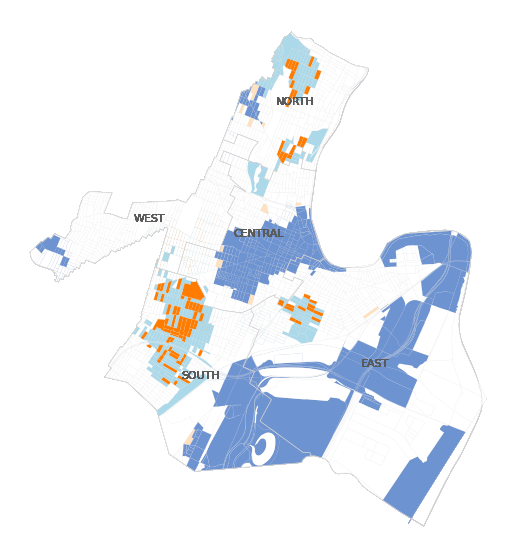

In [177]:
#Institutional Investor Rentals
moran_list = [moran2000_loc_inst_inv_rent,moran2001_loc_inst_inv_rent,moran2002_loc_inst_inv_rent,
             moran2003_loc_inst_inv_rent,moran2004_loc_inst_inv_rent,moran2005_loc_inst_inv_rent,
             moran2006_loc_inst_inv_rent,moran2007_loc_inst_inv_rent,moran2008_loc_inst_inv_rent, moran2009_loc_inst_inv_rent,
             moran2010_loc_inst_inv_rent,moran2011_loc_inst_inv_rent,moran2012_loc_inst_inv_rent,
             moran2013_loc_inst_inv_rent,moran2014_loc_inst_inv_rent,moran2015_loc_inst_inv_rent,
             moran2016_loc_inst_inv_rent,moran2017_loc_inst_inv_rent,moran2018_loc_inst_inv_rent]
files_list = ['inst_inv_rent2000.png','inst_inv_rent2001.png','inst_inv_rent2002.png','inst_inv_rent2003.png',
             'inst_inv_rent2004.png','inst_inv_rent2005.png','inst_inv_rent2006.png','inst_inv_rent2007.png',
             'inst_inv_rent2008.png','inst_inv_rent2009.png',
             'inst_inv_rent2010.png','inst_inv_rent2011.png','inst_inv_rent2012.png','inst_inv_rent2013.png',
             'inst_inv_rent2014.png','inst_inv_rent2015.png','inst_inv_rent2016.png','inst_inv_rent2017.png',
             'inst_inv_rent2018.png']
years = ['2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009',
        '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018']

fig, ax = plt.subplots(figsize=(10,10))
for i, val in enumerate(moran_list):
    lisa_cluster_cust(colors_investor, val, grouped_deeds, p=0.05, ax=ax, legend=False)
    #non_res.plot(ax=ax, edgecolor='none', color='#f5f5f5')
    wards.plot(ax=ax, facecolor='none', edgecolor='#D2D2D2', linewidth=0.5)
    wards.apply(lambda x: ax.annotate(s=x.WARD_NAME, xy=x.geometry.centroid.coords[0], ha='center', 
                                      fontsize = 11, color = '#5A5A5A'), axis=1);
    plt.savefig('IMAGES/Inst_Rent/'+files_list[i], dpi=300)

C:\Users\dmcna\anaconda3\envs\geo-2021\lib\site-packages\ipykernel_launcher.py:23: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
findfont: Font family ['Akkurat Pro'] not found. Falling back to DejaVu Sans.
C:\Users\dmcna\anaconda3\envs\geo-2021\lib\site-packages\ipykernel_launcher.py:23: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
C:\Users\dmcna\anaconda3\envs\geo-2021\lib\site-packages\ipykernel_launcher.py:23: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
C:\Users\dmcna\anaconda3\envs\geo-2021\lib\site-packages\ipykernel_launcher.py:23: MatplotlibDeprecationWarning: The 's' parameter of annotate() has

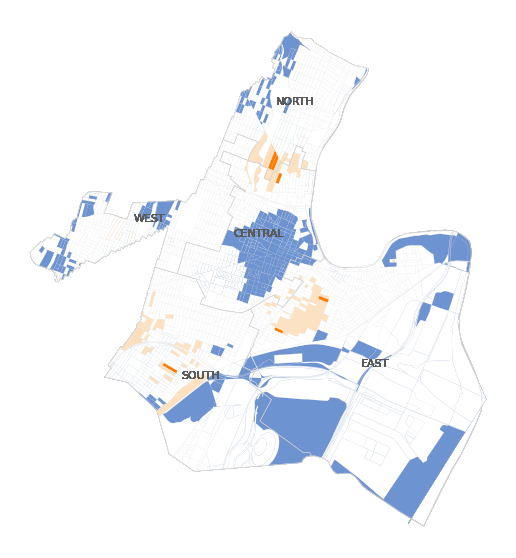

In [93]:
#Non-Institutional Investor Rentals
moran_list = [moran2000_loc_non_inst_inv_rent,moran2001_loc_non_inst_inv_rent,moran2002_loc_non_inst_inv_rent,
             moran2003_loc_non_inst_inv_rent,moran2004_loc_non_inst_inv_rent,moran2005_loc_non_inst_inv_rent,
             moran2006_loc_non_inst_inv_rent,moran2007_loc_non_inst_inv_rent,moran2008_loc_non_inst_inv_rent, moran2009_loc_non_inst_inv_rent,
             moran2010_loc_non_inst_inv_rent,moran2011_loc_non_inst_inv_rent,moran2012_loc_non_inst_inv_rent,
             moran2013_loc_non_inst_inv_rent,moran2014_loc_non_inst_inv_rent,moran2015_loc_non_inst_inv_rent,
             moran2016_loc_non_inst_inv_rent,moran2017_loc_non_inst_inv_rent,moran2018_loc_non_inst_inv_rent]
files_list = ['non_inst_inv_rent2000.png','non_inst_inv_rent2001.png','non_inst_inv_rent2002.png','non_inst_inv_rent2003.png',
             'non_inst_inv_rent2004.png','non_inst_inv_rent2005.png','non_inst_inv_rent2006.png','non_inst_inv_rent2007.png',
             'non_inst_inv_rent2008.png','non_inst_inv_rent2009.png',
             'non_inst_inv_rent2010.png','non_inst_inv_rent2011.png','non_inst_inv_rent2012.png','non_inst_inv_rent2013.png',
             'non_inst_inv_rent2014.png','non_inst_inv_rent2015.png','non_inst_inv_rent2016.png','non_inst_inv_rent2017.png',
             'non_inst_inv_rent2018.png']
years = ['2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009',
        '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018']

fig, ax = plt.subplots(figsize=(10,10))
for i, val in enumerate(moran_list):
    lisa_cluster_cust(colors_investor, val, grouped_deeds, p=0.05, ax=ax, legend=False)
    #non_res.plot(ax=ax, edgecolor='none', color='#f5f5f5')
    wards.plot(ax=ax, facecolor='none', edgecolor='#D2D2D2', linewidth=0.5)
    wards.apply(lambda x: ax.annotate(s=x.WARD_NAME, xy=x.geometry.centroid.coords[0], ha='center', 
                                      fontname='Akkurat Pro', fontsize = 11, color = '#5A5A5A'), axis=1);
    plt.savefig('IMAGES/Non_Inst_Rent/'+files_list[i], dpi=300)

C:\Users\dmcna\anaconda3\envs\geo-2021\lib\site-packages\ipykernel_launcher.py:23: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
C:\Users\dmcna\anaconda3\envs\geo-2021\lib\site-packages\ipykernel_launcher.py:23: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
C:\Users\dmcna\anaconda3\envs\geo-2021\lib\site-packages\ipykernel_launcher.py:23: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
C:\Users\dmcna\anaconda3\envs\geo-2021\lib\site-packages\ipykernel_launcher.py:23: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dr

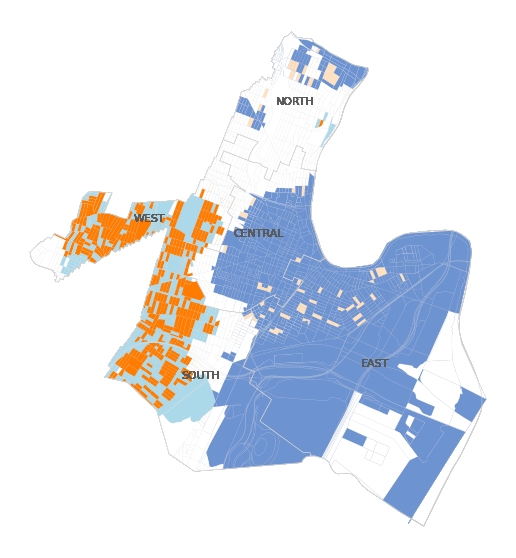

In [94]:
#Institutional Investor Flips
moran_list = [moran2000_loc_inst_inv_flip,moran2001_loc_inst_inv_flip,moran2002_loc_inst_inv_flip,
             moran2003_loc_inst_inv_flip,moran2004_loc_inst_inv_flip,moran2005_loc_inst_inv_flip,
             moran2006_loc_inst_inv_flip,moran2007_loc_inst_inv_flip,moran2008_loc_inst_inv_flip, moran2009_loc_inst_inv_flip,
             moran2010_loc_inst_inv_flip,moran2011_loc_inst_inv_flip,moran2012_loc_inst_inv_flip,
             moran2013_loc_inst_inv_flip,moran2014_loc_inst_inv_flip,moran2015_loc_inst_inv_flip,
             moran2016_loc_inst_inv_flip,moran2017_loc_inst_inv_flip,moran2018_loc_inst_inv_flip]
files_list = ['inst_inv_flip2000.png','inst_inv_flip2001.png','inst_inv_flip2002.png','inst_inv_flip2003.png',
             'inst_inv_flip2004.png','inst_inv_flip2005.png','inst_inv_flip2006.png','inst_inv_flip2007.png',
             'inst_inv_flip2008.png','inst_inv_flip2009.png',
             'inst_inv_flip2010.png','inst_inv_flip2011.png','inst_inv_flip2012.png','inst_inv_flip2013.png',
             'inst_inv_flip2014.png','inst_inv_flip2015.png','inst_inv_flip2016.png','inst_inv_flip2017.png',
             'inst_inv_flip2018.png']
years = ['2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009',
        '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018']

fig, ax = plt.subplots(figsize=(10,10))
for i, val in enumerate(moran_list):
    lisa_cluster_cust(colors_investor, val, grouped_deeds, p=0.05, ax=ax, legend=False)
    #non_res.plot(ax=ax, edgecolor='none', color='#f5f5f5')
    wards.plot(ax=ax, facecolor='none', edgecolor='#D2D2D2', linewidth=0.5)
    wards.apply(lambda x: ax.annotate(s=x.WARD_NAME, xy=x.geometry.centroid.coords[0], ha='center', 
                                      fontname='Akkurat Pro', fontsize = 11, color = '#5A5A5A'), axis=1);
    plt.savefig('IMAGES/Inst_Flip/'+files_list[i], dpi=300)

C:\Users\dmcna\anaconda3\envs\geo-2021\lib\site-packages\ipykernel_launcher.py:23: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
C:\Users\dmcna\anaconda3\envs\geo-2021\lib\site-packages\ipykernel_launcher.py:23: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
C:\Users\dmcna\anaconda3\envs\geo-2021\lib\site-packages\ipykernel_launcher.py:23: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
C:\Users\dmcna\anaconda3\envs\geo-2021\lib\site-packages\ipykernel_launcher.py:23: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dr

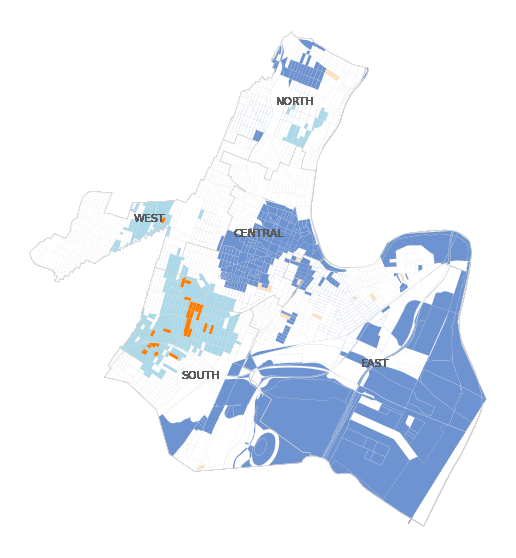

In [95]:
#Non-Institutional Investor Flips
moran_list = [moran2000_loc_non_inst_inv_flip,moran2001_loc_non_inst_inv_flip,moran2002_loc_non_inst_inv_flip,
             moran2003_loc_non_inst_inv_flip,moran2004_loc_non_inst_inv_flip,moran2005_loc_non_inst_inv_flip,
             moran2006_loc_non_inst_inv_flip,moran2007_loc_non_inst_inv_flip,moran2008_loc_non_inst_inv_flip, moran2009_loc_non_inst_inv_flip,
             moran2010_loc_non_inst_inv_flip,moran2011_loc_non_inst_inv_flip,moran2012_loc_non_inst_inv_flip,
             moran2013_loc_non_inst_inv_flip,moran2014_loc_non_inst_inv_flip,moran2015_loc_non_inst_inv_flip,
             moran2016_loc_non_inst_inv_flip,moran2017_loc_non_inst_inv_flip,moran2018_loc_non_inst_inv_flip]
files_list = ['non_inst_inv_flip2000.png','non_inst_inv_flip2001.png','non_inst_inv_flip2002.png','non_inst_inv_flip2003.png',
             'non_inst_inv_flip2004.png','non_inst_inv_flip2005.png','non_inst_inv_flip2006.png','non_inst_inv_flip2007.png',
             'non_inst_inv_flip2008.png','non_inst_inv_flip2009.png',
             'non_inst_inv_flip2010.png','non_inst_inv_flip2011.png','non_inst_inv_flip2012.png','non_inst_inv_flip2013.png',
             'non_inst_inv_flip2014.png','non_inst_inv_flip2015.png','non_inst_inv_flip2016.png','non_inst_inv_flip2017.png',
             'non_inst_inv_flip2018.png']
years = ['2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009',
        '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018']

fig, ax = plt.subplots(figsize=(10,10))
for i, val in enumerate(moran_list):
    lisa_cluster_cust(colors_investor, val, grouped_deeds, p=0.05, ax=ax, legend=False)
    #non_res.plot(ax=ax, edgecolor='none', color='#f5f5f5')
    wards.plot(ax=ax, facecolor='none', edgecolor='#D2D2D2', linewidth=0.5)
    wards.apply(lambda x: ax.annotate(s=x.WARD_NAME, xy=x.geometry.centroid.coords[0], ha='center', 
                                      fontname='Akkurat Pro', fontsize = 11, color = '#5A5A5A'), axis=1);
    plt.savefig('IMAGES/Non_Inst_Flip/'+files_list[i], dpi=300)

C:\Users\dmcna\anaconda3\envs\geo-2021\lib\site-packages\ipykernel_launcher.py:22: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
C:\Users\dmcna\anaconda3\envs\geo-2021\lib\site-packages\ipykernel_launcher.py:22: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
C:\Users\dmcna\anaconda3\envs\geo-2021\lib\site-packages\ipykernel_launcher.py:22: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
C:\Users\dmcna\anaconda3\envs\geo-2021\lib\site-packages\ipykernel_launcher.py:22: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dr

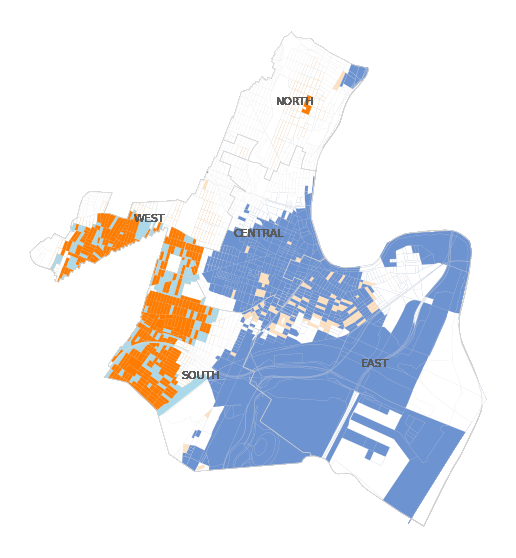

In [96]:
#Non Investor / Owner-Occ
moran_list = [moran2000_loc_non_inv,moran2001_loc_non_inv,moran2002_loc_non_inv,
             moran2003_loc_non_inv,moran2004_loc_non_inv,moran2005_loc_non_inv,
             moran2006_loc_non_inv,moran2007_loc_non_inv,moran2008_loc_non_inv, moran2009_loc_non_inv,
             moran2010_loc_non_inv,moran2011_loc_non_inv,moran2012_loc_non_inv,
             moran2013_loc_non_inv,moran2014_loc_non_inv,moran2015_loc_non_inv,
             moran2016_loc_non_inv,moran2017_loc_non_inv,moran2018_loc_non_inv]
files_list = ['non_inv2000.png','non_inv2001.png','non_inv2002.png','non_inv2003.png',
             'non_inv2004.png','non_inv2005.png','non_inv2006.png','non_inv2007.png',
             'non_inv2008.png','non_inv2009.png',
             'non_inv2010.png','non_inv2011.png','non_inv2012.png','non_inv2013.png',
             'non_inv2014.png','non_inv2015.png','non_inv2016.png','non_inv2017.png',
             'non_inv2018.png']
years = ['2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009',
        '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018']
fig, ax = plt.subplots(figsize=(10,10))
for i, val in enumerate(moran_list):
    lisa_cluster_cust(colors_investor, val, grouped_deeds, p=0.05, ax=ax, legend=False)
    #non_res.plot(ax=ax, edgecolor='none', color='#f5f5f5')
    wards.plot(ax=ax, facecolor='none', edgecolor='#D2D2D2', linewidth=0.5)
    wards.apply(lambda x: ax.annotate(s=x.WARD_NAME, xy=x.geometry.centroid.coords[0], ha='center', 
                                      fontname='Akkurat Pro', fontsize = 11, color = '#5A5A5A'), axis=1);
    plt.savefig('IMAGES/Non_Inv/'+files_list[i], dpi=300)